# Imports, Falgs and Data Save Configuration

## Imports

In [1]:
# General imports:
import numpy as np
import tempfile
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os
import optuna
from tqdm import tqdm
import csv

# TensorFlow and Keras imports:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.activations import relu
# from keras.models import Model
# from tensorflow.keras.layers import TimeDistributed


# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler


# Torch imports:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR # Reduces the learning rate at regular intervals without considering the model's performance (reduces the learning rate after a specified number of epochs).
from torch.optim.lr_scheduler import ReduceLROnPlateau # dapts the learning rate based on the model's performance, usually when the performance plateaus (educes the learning rate when a specified metric (usually a loss) stops improving). 


# DGL Imports:
import dgl
import dgl.function as fn
from dgl.nn import GraphConv
from dgl.nn.pytorch import GATConv
import dgl.nn as dglnn
from dgl.dataloading import GraphDataLoader


import time
start_time = time.time()

### Device

In [2]:
"Set the device:"
MPS_device = False
CPU_GPU_device = True

#---------------------------------------------------------------------------------------------------------------#





if MPS_device:
    r"""
    Accelerated PyTorch training on Mac
    ----------------------------------------------------------------
    PyTorch uses the new Metal Performance Shaders (MPS) backend for GPU training acceleration.
    This MPS backend extends the PyTorch framework, providing scripts and capabilities to set up and run operations on Mac.
    The MPS framework optimizes compute performance with kernels that are fine-tuned for the unique characteristics of each Metal GPU family.
    The new mps device maps machine learning computational graphs and primitives on the MPS Graph framework and tuned kernels provided by MPS.
    """

    import torch

    if torch.backends.mps.is_available(): # This checks if the MPS backend is available for PyTorch. MPS stands for "Metal Performance Shaders", a technology by Apple that accelerates computation on the GPU.
        mps_device = torch.device("mps")
        x = torch.ones(1, device=mps_device)
        print(x)
    else:
        print("MPS device not found.")


    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(device)

    print(torch.backends.mps.is_available())

    
    


if CPU_GPU_device:
    # torch.cuda.set_device(1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

cpu


## Flags

In [3]:
#---------------------------------------#
"Main event under investigation"
ss_dd_events = True
bb_events = False







#---------------------------------------#
"Choose wether to use Energy and to load/save the graphs"
# Energy check
no_energy = False

# Save/Load the graphs
save_graphs = False
load_graphs = False






# Choose the number of jets/graphs for the model 

#---------------------------------------#
"Choose the number of jets/graph"
partial_model = True
jets_number = 1000
graph_number = 100000






# Choose the file and environment

#---------------------------------------#
"Pc"
pc_file_flag_200 = False
pc_file_flag_45 = True


#---------------------------------------#
"Cluster"
cluster_file_flag_200 = False
cluster_file_flag_45 = False





# Choose the model and training

#---------------------------------------#
"Choose the model you want to run"
GCN_model = False
ParT_model = True
MLP_model = False


#---------------------------------------#
"Choose the training you want to use"
regular_training_flag= True
optuna_flag = False



## Data save

In [4]:
from datetime import datetime

# Get the current date and time
now = datetime.now()

# Transform it as a string in the format "Year-Month-Day Hour-Minute-Second"
date_time_string = now.strftime("%Y-%m-%d %H-%M-%S")

model_name = "GCN" if GCN_model else ("ParT" if ParT_model else ("MLP" if MLP_model else ""))
model_type = "Partial_model" if partial_model else "Full_model"
suffix = "Without Energy" if no_energy else ""

# Set the folder name based on the flags
if regular_training_flag:
    if cluster_file_flag_200:
        folder_name = f'{model_name} {model_type}_200 {suffix} {date_time_string}'
    elif cluster_file_flag_45:
        folder_name = f'{model_name} {model_type}_45 {suffix} {date_time_string}'
    else:
        folder_name = f'{model_name} {model_type} {suffix} {date_time_string}'
elif optuna_flag:
    if cluster_file_flag_200:
        folder_name = f'{model_name} Optuna_Model_200 {suffix} {date_time_string}'
    elif cluster_file_flag_45:
        folder_name = f'{model_name} Optuna_Model_45 {suffix} {date_time_string}'
    else:
        folder_name = f'{model_name} Optuna Model {suffix} {date_time_string}'

if ss_dd_events: 
    if cluster_file_flag_200 or cluster_file_flag_45:
        dir_path = f'/gpfs0/kats/users/edoof/python/GNN Graphs/s_tagger/{folder_name}'

    if pc_file_flag_200:
        dir_path = f'/Users/Edo/Desktop/לימודים/תואר שני/מחקר/תזה/figures for s-tagger pT=200 {suffix}'

    if pc_file_flag_45:
        dir_path = f'/Users/Edo/Desktop/לימודים/תואר שני/מחקר/תזה/figures for s-tagger pT=45 {suffix}'


if bb_events:    
    if cluster_file_flag_200 or cluster_file_flag_45:
        dir_path = f'/gpfs0/kats/users/edoof/python/GNN Graphs/b_baryon_meson_tagger/{folder_name}'

    if pc_file_flag_200:
        dir_path = f'/Users/Edo/Desktop/לימודים/תואר שני/מחקר/תזה/figures for b-tagger pT=200 {suffix}'

    if pc_file_flag_45:
        dir_path = f'/Users/Edo/Desktop/לימודים/תואר שני/מחקר/תזה/figures for b-tagger pT=45 {suffix}'

    
suffix_1 = "200" if pc_file_flag_200 or cluster_file_flag_200 else ("45" if pc_file_flag_45 or cluster_file_flag_45 else "")
    
    
def save_figure(plt, file_name):
    global dir_path  # This line tells the function to use the global variable 'dir_path'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    plt.savefig(os.path.join(dir_path, '{}.png'.format(file_name)), dpi=150, bbox_inches='tight')


def save_model_parameter(key, value):
    global dir_path
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)  
    with open(os.path.join(dir_path, "model_parameters.txt"), "a") as file: 
        file.write(f"{key}: {value}\n")

        
def generate_model_prediction_filename():
    model_name = "GCN" if GCN_model else ("ParT" if ParT_model else ("MLP" if MLP_model else ""))
    energy_suffix = "WithoutEnergy" if no_energy else "WithEnergy"
    pt_suffix = "200pT" if (pc_file_flag_200 or cluster_file_flag_200) else "45pT"
    file_name = f"{model_name}_{energy_suffix}_{pt_suffix}_predictions_and_labels.csv"
    
    return file_name

        
def save_best_params(study):
    global dir_path
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    with open(os.path.join(dir_path, "results.txt"), "w") as file:
        file.write(f"Best trial: {study.best_trial.number}\n")
        file.write(f"Best value (validation loss): {study.best_trial.value}\n")
        file.write("Best hyperparameters:\n")
        for key, value in study.best_trial.params.items():
            file.write(f"  {key}: {value}\n")
        
        file.write("\nAll trials:\n")
        file.write(str(study.trials_dataframe()))
        
        
if ss_dd_events:         
    pc_base_path = f'/Users/Edo/Desktop/לימודים/תואר שני/מחקר/תזה/Graphs Save {suffix}/s_graphs'
    cluster_base_path = f'/gpfs0/kats/users/edoof/python/Graphs Save {suffix}/s_graphs'

if bb_events:
    pc_base_path = f'/Users/Edo/Desktop/לימודים/תואר שני/מחקר/תזה/Graphs Save {suffix}/b_baryon_meson_graphs'
    cluster_base_path = f'/gpfs0/kats/users/edoof/python/Graphs Save {suffix}/b_baryon_meson_graphs'

# Determine if running on PC or cluster
if pc_file_flag_200 or pc_file_flag_45:
    save_path = load_path = pc_base_path
elif cluster_file_flag_200 or cluster_file_flag_45:
    save_path = load_path = cluster_base_path

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)


# Data preparation

## Importing data

In [5]:

if not load_graphs and not MLP_model:
    def read_data_from_file_v2(file_name):
        data = []
        jets_pT = []
        jet_eta = []
        jets_constituents_number = []
        jet_energy = []

        num_pt_low = 0  # Variable to count the jets below the pT threshold


        with open(file_name) as f:
            while True:  # Iterate over each line in the file
                line = f.readline()
                if not line:
                    break

                line_as_array = line.strip().split()  # Split the line on whitespace and store in an array
                line_as_array_floats = list(map(float , line_as_array))

                if line_as_array_floats[0] < pT:  # Apply a pT cut
                    num_pt_low += 1
                    continue  # Skip this jet and move to the next one

                # Append to an array the jet featuers
                jets_pT.append(line_as_array_floats[0])
                jet_eta.append(line_as_array_floats[1])
                jets_constituents_number.append(line_as_array_floats[2])

                # Append the energy components to jet_energy
                jet_energy.append(line_as_array_floats[3:10])


                # Exclude the energy components if no_energy flag set to True.
                if no_energy:
                    # Add only the jet features and the remaining constituents elements (excluding 3:10) to the data list
                    data.append(line_as_array_floats[:3] + line_as_array_floats[10:])
                else:
                    # Include the energy components
                    data.append(line_as_array_floats)

    #             data.append(line_as_array_floats)

        # Filter out rows where the last element is 2 (means it is not a s-quark or d-quark jets)
        num_filtered = len(data)
        data = [row for row in data if row[-1] != 2]
        num_filtered -= len(data)

        print(f'Number of jets with pT < {pT}:', num_pt_low)
        if ss_dd_events:
            print("Number of rows filtered out (no s/d jets):", num_filtered)
        if bb_events:
            print("Number of rows filtered out (no bryon/meson inside the jet):", num_filtered)
        print("Number of jets", len(data))

        return data, jets_pT, jet_eta, jets_constituents_number, jet_energy


    if ss_dd_events:
        if pc_file_flag_200:
            pT = 200
            file_name = "/Users/Edo/Simulations/pythia8310/examples/mymainstagger - ssbar_ddbar_creation"

        elif pc_file_flag_45:
            file_name = "/Users/Edo/Simulations/pythia8310/examples/mymainstagger - ssbar_ddbar_creation_low_energy"
            pT = 45

        elif cluster_file_flag_200:
            file_name = "/gpfs0/kats/users/edoof/python/jobs/mymainstagger - ssbar_ddbar_creation"
            pT = 200

        elif cluster_file_flag_45: 
            file_name = "/gpfs0/kats/users/edoof/python/jobs/mymainstagger - ssbar_ddbar_creation_low_energy"
            pT = 45

        else:
            raise ValueError("No flag is set to True, please set one of the flags to True.")
    
    if bb_events:
        if pc_file_flag_200:
            pT = 200
            file_name = "/Users/Edo/Simulations/pythia8310/examples/mymain_b_meson_baryon_tagger - bbbar_creation"

        elif pc_file_flag_45:
            file_name = "/Users/Edo/Simulations/pythia8310/examples/mymain_b_meson_baryon_tagger - bbbar_creation_low_energy"
            pT = 45

        elif cluster_file_flag_200:
            file_name = "/gpfs0/kats/users/edoof/python/jobs/mymain_b_meson_baryon_tagger - bbbar_creation"
            pT = 200

        elif cluster_file_flag_45: 
            file_name = "/gpfs0/kats/users/edoof/python/jobs/mymain_b_meson_baryon_tagger - bbbar_creation_low_energy"
            pT = 45

        else:
            raise ValueError("No flag is set to True, please set one of the flags to True.")

        
    all_data, jets_pT, jet_eta, jets_constituents_number, jet_energy = read_data_from_file_v2(file_name)




Number of jets with pT < 45: 482375
Number of rows filtered out (no s/d jets): 0
Number of jets 1517625


In [6]:
if not load_graphs and bb_events and not MLP_model:
    import random

    # Step 1: Count the jets with each label
    jets_with_b_meson = [jet for jet in all_data if jet[-1] == 0]
    jets_with_b_baryon = [jet for jet in all_data if jet[-1] == 1]
    print(f"Initial number of jets with b-meson: {len(jets_with_b_meson)}")
    print(f"Initial number of jets with b-baryon: {len(jets_with_b_baryon)}")

    # Step 2 & 3: Adjust proportions to 70% meson and 30% baryon
    desired_proportion_baryon = 0.3
    total_desired_jets = len(jets_with_b_baryon) / desired_proportion_baryon  # Calculate the total desired number of jets based on 30% being baryon
    desired_num_meson_jets = total_desired_jets * (1 - desired_proportion_baryon)  # Calculate the number of meson jets to achieve the desired proportion

    # Randomly sample from the meson jets to reduce their count
    filtered_meson_jets = random.sample(jets_with_b_meson, int(desired_num_meson_jets))

    # Combine the filtered meson jets with all the baryon jets
    all_data = filtered_meson_jets + jets_with_b_baryon

    # Mix the lists so we won't have first lists of meson jets and then baryon jets
    random.shuffle(all_data)

    # Step 4: Print the final counts
    final_meson_count = sum(1 for jet in all_data if jet[-1] == 0)
    final_baryon_count = sum(1 for jet in all_data if jet[-1] == 1)
    save_model_parameter("Number of jets with b-baryon", final_meson_count)
    save_model_parameter("Number of jets with b-baryon", final_baryon_count)
    print(f"Final number of jets with b-meson: {final_meson_count}")
    print(f"Final number of jets with b-baryon: {final_baryon_count}")
    
    
    # Initialize the lists to store the updated data
    updated_jets_pT = []
    updated_jet_eta = []
    updated_jets_constituents_number = []
    updated_jet_energy = []

    # Iterate through the balanced all_data to extract the updated jet information
    for jet in all_data:
        updated_jets_pT.append(jet[0])
        updated_jet_eta.append(jet[1])
        updated_jets_constituents_number.append(jet[2])
        updated_jet_energy.append(jet[3:10])  # Assuming the jet energy components are from index 3 to 8

    # Overwrite the original variables with their updated versions
    jets_pT = updated_jets_pT
    jet_eta = updated_jet_eta
    jets_constituents_number = updated_jets_constituents_number
    jet_energy = updated_jet_energy



In [7]:
# for i in range(10):
#     print(jets_constituents_number[i])

In [8]:
# for i in range(10):
#     print(all_data[i])

In [9]:
# len(all_data)

In [10]:
# print(all_data[2])

In [11]:
if not load_graphs and not MLP_model:
    if partial_model:
        all_data = all_data[0:jets_number]

    save_model_parameter("Number of jets", len(all_data))

In [12]:
# for i in range(len(all_data)):
#     print(all_data[i])

In [13]:
# for i in range(len(all_data)):
#     print((len(all_data[i]) - 10)/9) # 10 = 9 jet features + 1 label, 9 = 9 constituent features


## Scale The Data

The StandardScaler is standardizes features by removing the mean and scaling to unit variance.
Here's how it works:

* Calculate the mean: For each feature (or column in the data), calculate the mean (average) value.

* Subtract the mean from the feature values: This process is also known as "centering" the data. After this step, the feature will have a mean of 0.

* Calculate the variance: For each feature, calculate the variance. Variance is a statistical measurement that describes the spread of the data: a high variance means that the data is spread out; a low variance means it's close together.

* Divide the features (already mean-centered) by their standard deviation: The standard deviation is the square root of the variance. Dividing by the standard deviation scales the data to have a variance of 1.

This method of scaling is often used in machine learning (ML) algorithms as it can help the algorithm converge faster and can also help prevent certain features from dominating solely because they have larger values.

In [14]:
if not load_graphs and not MLP_model:

    # create the scaler
    scaler = StandardScaler()

    # For the first three features of each jet
    for i in range(3):
        # Collect the i-th feature from each jet
        feature_values = [jet[i] for jet in all_data]
        # Scale the collected features
        scaled_values = scaler.fit_transform(np.array(feature_values).reshape(-1, 1)).flatten()
        # Apply the scaling to the jets
        for j, jet in enumerate(all_data):
            jet[i] = scaled_values[j]

In [15]:
# for i in range(4):
#     print(all_data[i])

## Create Nodes

In [16]:
if not load_graphs and not MLP_model:
    if no_energy:
        num_jet_features = 3 # pT, eta, Number of constituents
    else:
        num_jet_features = 10 # pT, eta, Number of constituents and 7 for the total energies

    num_constituent_features = 9 # 6 for identity, rel_pT, r, alpha

    num_node_features = num_jet_features + num_constituent_features
    
    
    def create_nodes_from_data(data):
        all_jets_data = []
        jet_labels = []

        for row in data:
            jet_features = row[:num_jet_features]
            label = row[-1]
            jet_labels.append(label)

            num_constituents = (len(row) - num_jet_features - 1) // num_constituent_features 

            jet_nodes = [] # nodes of this jet

            for i in range(num_constituents): 
                constituent_features = row[num_jet_features + (i * num_constituent_features) : num_node_features + ((i) * num_constituent_features)]
                node = np.concatenate((jet_features, constituent_features))
                jet_nodes.append(node)

            all_jets_data.append(jet_nodes)

        jet_labels = np.array(jet_labels)

        print("The number of jets:", len(all_jets_data))
        print("The number of labels:", len(jet_labels))

        return all_jets_data, jet_labels

    all_jets_data, jet_labels = create_nodes_from_data(all_data)

The number of jets: 1000
The number of labels: 1000


## Create Full Graph

In [17]:
if not load_graphs and not MLP_model:
    def euclidean_distance_single_feature(a, b, index):
        return 1 / (torch.sqrt((a[index] - b[index]) ** 2) + 1e-8)

    # def euclidean_distance_single_feature(a, b, index):
    #     return 1 / (torch.abs(a[index] - b[index]) + 1e-8)


    def prepare_dgl_graphs(all_jets_data, jet_labels, device):
        num_jets = len(jet_labels)

        dgl_graphs = [] # Initialize an empty list to store the DGL graphs for each jet.

    #     for i in range(num_jets):
        for i in tqdm(range(num_jets), desc="Preparing graphs"):
            num_constituents = len(all_jets_data[i])

    #         node_features = all_jets_data[i]
            node_features = np.array(all_jets_data[i])
            node_features = torch.tensor(node_features, dtype=torch.float32)


            if num_constituents > 1:
                edges = np.array([[i, j] for i in range(num_constituents) for j in range(i+1, num_constituents)]).T
                edges = torch.tensor(edges, dtype=torch.int64)

                relevant_indices = [-3, -2, -1] # indices for rel_pT, r, alpha in each node

                # Here, we loop over each feature index and compute the distance for each edge.
                # This will result in a list of lists, where the outer list corresponds to each feature and the inner list corresponds to distances for all node pairs for that specific feature.
                edge_weights_lists = [[euclidean_distance_single_feature(node_features[i], node_features[j], idx) 
                                      for i in range(num_constituents) 
                                      for j in range(i+1, num_constituents)] 
                                     for idx in relevant_indices]

                # Now, we want to transform our list of lists into a NumPy array (or tensor) of shape [num_edges, 3].
                # The transpose operation here will help us achieve that shape.
                edge_weights_array = np.array(edge_weights_lists).T
                edge_weights = torch.tensor(edge_weights_array, dtype=torch.float32)

                # Convert edge_weights_lists to a PyTorch tensor directly on the MPS device
                # edge_weights_tensor = torch.stack([torch.stack(edge_weights) for edge_weights in edge_weights_lists], dim=1)
                # edge_weights = edge_weights_tensor.reshape(-1, len(relevant_indices))

                # Create DGL graph and add node features and edge weights
                g = dgl.graph((edges[0], edges[1]), num_nodes=num_constituents)
                g.ndata['feat'] = node_features
                g.edata['weight'] = edge_weights # This line concatenates the original edge weights with themselves, effectively doubling the edge weights to match the doubled number of edges. 
                g = dgl.add_reverse_edges(g, copy_edata = True) # Add a reverse edge for each edge in the original graph

            else:
                # If there's only one node, edges and edge_weights would be empty.
                edges = torch.empty((2, 0), dtype=torch.int64)
                edge_weights = torch.zeros(1, dtype=torch.float32)

                g = dgl.graph((edges[0], edges[1]), num_nodes=num_constituents)
                g.ndata['feat'] = node_features

            # Add the jet label as a graph-level attribute
            g.glabel = torch.tensor(jet_labels[i], dtype=torch.float32).to(device)


            dgl_graphs.append(g)

        return dgl_graphs

    dgl_graphs = prepare_dgl_graphs(all_jets_data, jet_labels, device)

Preparing graphs: 100%|████████████████████| 1000/1000 [00:04<00:00, 232.57it/s]


In [ ]:
if save_graphs and not MLP_model:
    torch.save(dgl_graphs, os.path.join(save_path, f'dgl_graphs {suffix_1} {suffix}.pt'))

In [ ]:
if load_graphs and not MLP_model:
    start_load_time = time.time()
    dgl_graphs = torch.load(os.path.join(load_path, f'dgl_graphs {suffix_1} {suffix}.pt'))

    end_load_time = time.time()
    load_duration = end_load_time - start_load_time
    load_duration_minutes = load_duration / 60
    load_duration_minutes_formatted = "{:.2f}".format(load_duration_minutes)
    save_model_parameter("Time to load graphs (minutes)", load_duration_minutes_formatted)
    
    if partial_model:
        dgl_graphs = dgl_graphs[:graph_number]

if not MLP_model:
    save_model_parameter("Number of graphs", len(dgl_graphs))

In [ ]:
if not MLP_model:
    graph_num = 0
    print("Number of DGL graphs:", len(dgl_graphs))
    print("Node features shape (example):", dgl_graphs[graph_num].ndata['feat'].shape) # [number of nodes, number of features]
    print("Edges shape (example):", dgl_graphs[graph_num].edges()[0].shape)
    print("Edge weights shape (example):", dgl_graphs[graph_num].edata['weight'].shape)
    print("Jet label (example):", dgl_graphs[graph_num].glabel)

In [ ]:
if not MLP_model:
    # Count the Number of d-jet graphs and s-jet graphs
    num_label_0 = 0
    num_label_1 = 0

    for graph in dgl_graphs:
        if graph.glabel == 0:
            num_label_0 += 1
        elif graph.glabel == 1:
            num_label_1 += 1
        else:
            print(f'Warning: graph has unexpected label {graph.glabel}')

    print(f'Number of graphs with label 0: {num_label_0}')
    print(f'Number of graphs with label 1: {num_label_1}')


    save_model_parameter("Number of graphs with label 0", num_label_0)
    save_model_parameter("Number of graphs with label 1", num_label_1)

## Split the data into train, test and validation

In [ ]:
if not MLP_model:
    # It splits the input graphs into training, testing and validation sets using sklearn 
    # The function returns the training, testing and validation sets as separate lists of graphs.

    train_dgl_graphs, test_dgl_graphs = train_test_split(dgl_graphs, test_size=0.1, random_state=42, shuffle=True)
    train_dgl_graphs, val_dgl_graphs = train_test_split(train_dgl_graphs, test_size=0.2, random_state=42, shuffle=True)

    # Balance the test set
    test_dgl_graphs_label_0 = [graph for graph in test_dgl_graphs if graph.glabel.item() == 0]
    test_dgl_graphs_label_1 = [graph for graph in test_dgl_graphs if graph.glabel.item() == 1]
    min_test_graphs = min(len(test_dgl_graphs_label_0), len(test_dgl_graphs_label_1))
    balanced_test_dgl_graphs = test_dgl_graphs_label_0[:min_test_graphs] + test_dgl_graphs_label_1[:min_test_graphs]

    # Shuffle the balanced test set
    np.random.shuffle(balanced_test_dgl_graphs)

    # Print the number of graphs with each label in the balanced test set
    print("Number of graphs with label 0:", len(test_dgl_graphs_label_0[:min_test_graphs]))
    print("Number of graphs with label 1:", len(test_dgl_graphs_label_1[:min_test_graphs]))

    # Print the number graph used for training, validation, test and balanced
    print(f"\nNumber of train graphs: {len(train_dgl_graphs)}")
    print(f"Number of validation graphs: {len(val_dgl_graphs)}")
    print(f"Number of test graphs: {len(test_dgl_graphs)}")
    print(f"Number of balanced test graphs: {len(balanced_test_dgl_graphs)}")



    save_model_parameter("Number of train graphs:", len(train_dgl_graphs))
    save_model_parameter("Number of validation graphs:", len(val_dgl_graphs))
    save_model_parameter("Number of balanced test graphs:", len(balanced_test_dgl_graphs))

## Create JetDataset

In [ ]:
if not MLP_model:
    def print_graph_shapes(dgl_graphs, name):
        num_graphs = len(dgl_graphs)
        num_nodes = dgl_graphs[0].number_of_nodes()
        num_features = dgl_graphs[0].ndata['feat'].shape[1]
        num_edges = dgl_graphs[0].number_of_edges()
        labels = [graph.glabel.item() for graph in dgl_graphs]
        label_shape = (num_graphs,)

        print(f"{name} inputs:")
        print(f"Node features shape: ({num_graphs}, {num_nodes}, {num_features})")
        print(f"Preprocessed edges shape: ({num_graphs}, 2, {num_edges})")
        print(f"Edge weights shape: ({num_graphs}, {num_edges})")
        print(f"Jet labels shape: {label_shape}")
        print()

    print_graph_shapes(train_dgl_graphs, "Train")
    print_graph_shapes(val_dgl_graphs, "Validation")
    print_graph_shapes(test_dgl_graphs, "Test")


<font size=4> To efficiently manage and load the data during training and evaluation, we create custom datasets using PyTorch. We define a class, JetDataset, that takes in the prepared DGL graphs. This class is equipped with methods to retrieve the total number of graphs and to fetch a graph and its label at a specific index. Utilizing this class, we create datasets for training, validation, and testing. These datasets are essential for batching and loading data in a structured manner, which is particularly beneficial in the context of neural network training.

In [ ]:
if not MLP_model:
    # Here we create PyTorch detasets and detaloaders to efficiently manage and load the data during training and evaluation.
    class JetDataset(Dataset):
        def __init__(self, dgl_graphs):
            self.graphs = [(g, g.glabel) for g in dgl_graphs]

        def __len__(self):  # Returns the total number of graphs in the dataset
            return len(self.graphs)

        def __getitem__(self, idx): # Returns the graphs and label at the specific index 'idx'
              # Remove the extra dimension from the labels
            return self.graphs[idx]

    train_dataset = JetDataset(train_dgl_graphs)
    val_dataset = JetDataset(val_dgl_graphs)
    test_dataset = JetDataset(balanced_test_dgl_graphs)

In [ ]:
# def collate(samples):
#     # The input `samples` is a list of data pairs [(graph, label)]
#     graphs, labels = map(list, zip(*samples))
#     batched_graph = dgl.batch(graphs)
#     return batched_graph, torch.tensor(labels).to(device)


In [ ]:
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)

# Model Architecture

## GCN Architecture

In [ ]:
if GCN_model:
    # Define MLPs for the embeddings
    class NodeEmbedding(nn.Module):
        def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
            super(NodeEmbedding, self).__init__()
            self.mlp = nn.Sequential(
                nn.Linear(input_dim, hidden_dim_1),
                nn.GELU(),
                nn.LayerNorm(hidden_dim_1),
                nn.Linear(hidden_dim_1, hidden_dim_2),
                nn.GELU(),
                nn.LayerNorm(hidden_dim_2),
                nn.Linear(hidden_dim_2, output_dim)
            )

        def forward(self, h):
            return self.mlp(h)

        
    class EdgeWeightEmbedding(nn.Module):
        def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
            super(EdgeWeightEmbedding, self).__init__()
            self.mlp = nn.Sequential(
                nn.Linear(input_dim, hidden_dim_1),
                nn.GELU(),
                nn.LayerNorm(hidden_dim_1),
                nn.Linear(hidden_dim_1, hidden_dim_2),
                nn.GELU(),
                nn.LayerNorm(hidden_dim_2),
                nn.Linear(hidden_dim_2, output_dim),
                nn.Sigmoid()
            )

        def forward(self, w):
            return self.mlp(w)

In [ ]:
if GCN_model:
    # h - tensor that representing the node featuers with shape (Num_nodes, Num_features)

    def compute_new_edge_weights(h):
    # def compute_new_edge_weights(h, num_feats):
    #     h = h[:, :num_feats]  # Slice the feature tensor to only consider the first 'num_feats' features
        h_expanded = h.unsqueeze(1).expand(-1, h.size(0), -1) # expend h alond dimension 1 to craete the shape of (Num_nodes,Num_nodes, Num_features) - each row is a duplicate of the original node features
        h_t_expanded = h.unsqueeze(0).expand(h.size(0), -1, -1)  # expend h alond dimension 0 to craete the shape of (Num_nodes,Num_nodes, Num_features) - each column is a duplicate of the original node features.
        pairwise_distance = torch.sqrt(torch.sum((h_expanded - h_t_expanded) ** 2, dim=2) + 1e-8) # We add small constant (1e-8) to avoid division by zero
        inverse_distance = 1.0 / pairwise_distance
        return inverse_distance
    
      
    class EdgeTransform(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EdgeTransform, self).__init__()
            self.transform = nn.Sequential(
                nn.Linear(input_dim, output_dim),
                nn.Sigmoid()
            )

        def forward(self, edge_weights):
            return self.transform(edge_weights)



    class CustomConv(nn.Module):
        def __init__(self, in_feats, out_feats):
            super(CustomConv, self).__init__()
            self.in_feats = in_feats
            self.out_feats = out_feats
            self.linear = nn.Linear(in_feats, out_feats)# Includes learnable bias parameter.

            self.linear_block = nn.Sequential(
                nn.Linear(in_feats, 2 * in_feats),
                nn.GELU(),
                nn.LayerNorm(2 * in_feats),
                nn.Linear(2 * in_feats, out_feats)
            )

        def forward(self, g, h, w):
            with g.local_scope():
                g.ndata['h'] = h
                g.edata['w'] = w

                # Message function: multiply source node features with edge weights
                g.apply_edges(fn.u_mul_e('h', 'w', 'm')) # Applies the message function to each edge in the graph. It multiplies the source node features ('h') by the edge weights ('w') and stores the result in the edge features ('m').

                # Sum up weighted features of neighbors and take the average          
                g.update_all(fn.copy_e('m', 'm'), fn.sum('m', 'h_new')) # Sums the incoming messages 'm' (weighted features) for each node and stores the result in 'h_new_sum'.
                # The reason for using fn.copy_e('m', 'm') is that the messages have already been computed and stored in the edge feature 'm'. 
                # So, the message function simply copies the already computed message from edge feature 'm' to another edge feature, also called 'm'. 
                # This way, it doesn't modify the message and allows the reduce function to work on the same message.

                # Calculate the mean manually, considering self-connections
                h_new = g.ndata['h_new'] + h  # Adds the original node features h (self-connections) to the summed incoming messages g.ndata['h_new_sum'], which is equivalent to adding the self-connections (the node's features with a weight of 1).
                h_new_avg = h_new / (g.in_degrees().float().view(-1, 1) + 1) # calculates the final average of the new node features by considering the self-connection (which is why we add 1 to the in-degrees).  

                # Apply the linear layer which applies both the weight matrix and the bias 
#                 h_new_avg = self.linear(h_new_avg)
                h_new_avg = self.linear_block(h_new_avg)

                return h_new_avg


    class CustomGNN(nn.Module):
        def __init__(self, node_input_dim, hidden_dim_nodes_1, hidden_dim_nodes_2, output_dim_nodes, 
                     edge_input_dim, hidden_dim_edges_1, hidden_dim_edges_2, output_dim_edges,
                     num_convs, output_dim_conv_block, output_dim, dropout_rate):
            super(CustomGNN, self).__init__()

            self.node_embedding = NodeEmbedding(node_input_dim, hidden_dim_nodes_1, hidden_dim_nodes_2, output_dim_nodes)
            self.edge_weight_embedding = EdgeWeightEmbedding(edge_input_dim, hidden_dim_edges_1, hidden_dim_edges_2, output_dim_edges)
            
            
            self.convs = nn.ModuleList()
            for i in range(num_convs):
                self.convs.append(CustomConv(output_dim_nodes, output_dim_conv_block))
                
                
            self.edge_transform = EdgeTransform(1, 1) # ensures that a scalar enters and a scalar comes out
            

            self.linear1 = nn.Linear(2 * output_dim_conv_block, output_dim)
            self.linear2 = nn.Linear(output_dim, 1)
            
            
            self.dropout = nn.Dropout(dropout_rate) # Add dropout layer

        def forward(self, g, h, w):
    #     def forward(self, g, h, w, num_feats):

            "Node/Edge Embeddings"
            h = self.node_embedding(h)
            w = self.edge_weight_embedding(w)
            
            
            "GCN Layers"
            for conv in self.convs:
                h = conv(g, h, w)
                h = self.dropout(h)
#                 new_edge_weights = compute_new_edge_weights(h, num_feats)
                new_edge_weights = compute_new_edge_weights(h) # Compute new edge weights based on the inverse Euclidean distance
                # Flatten the new_edge_weights matrix and only keep the relevant edge weights
                src, dst = g.edges() # Get the source and destination nodes for each edge in the graph g
                new_edge_weights_flat = new_edge_weights[src, dst]  # Use the source and destination nodes to index into the new_edge_weights matrix and get the corresponding edge weights.
                
                if transformed_edges:
                    new_edge_weights_flat = self.edge_transform(new_edge_weights_flat.unsqueeze(-1)).squeeze(-1)
    
                g.edata['w'] = new_edge_weights_flat # Update edge weights with the new edge weights

                

            "Linear Block"
            g.ndata['h'] = h
            # Mean of the node features for each graph in the batch 
            h_1 = dgl.mean_nodes(g, 'h')
            h_2 = dgl.sum_nodes(g, 'h')
            h = torch.cat([h_1, h_2], dim=-1)
            
            h = self.linear1(h)
            h = F.gelu(h)
            h = self.linear2(h)



            return torch.sigmoid(h) # Apply sigmoid activation function to get a result between 0 and 1

### Hyperparameters

In [ ]:
if GCN_model:
    # Prepare the batch date using GraphDataLoader
    batch_size = 128
    train_dataloader = GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = GraphDataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = GraphDataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    "Embedding Stage"
    # NodeEmbedding Parameters
    node_input_dim = dgl_graphs[0].ndata['feat'].shape[1]
    hidden_dim_nodes_1 = 128
    hidden_dim_nodes_2 = 512
    output_dim_nodes = 128
    # RelationEmbedding Parameters
    edge_input_dim = dgl_graphs[0].edata['weight'].shape[1]
    hidden_dim_edges_1 = 32
    hidden_dim_edges_2 = 64
    output_dim_edges = 1
    

    "GCN Layer"
    num_convs = 10
    output_dim_conv_block = output_dim_nodes
    transformed_edges = True
    
    "Linear Block"
    output_dim = 64



    dropout_rate = 0.1
    # num_feats = 8


    model = CustomGNN(node_input_dim, hidden_dim_nodes_1, hidden_dim_nodes_2, output_dim_nodes, 
                      edge_input_dim, hidden_dim_edges_1, hidden_dim_edges_2, output_dim_edges,
                      num_convs, output_dim_conv_block, output_dim, dropout_rate)
    model = model.to(device)


    "Loss Function and Optimizer"
    # Define loss function and optimizer
    loss_func = torch.nn.BCELoss() # Binary Cross-Entropy Loss function
    learning_rate = 0.0001
    
    
    print("batch size:", batch_size)
    print("Number of Convolutional layers:", num_convs)
    print("learning rate:", learning_rate)
    save_model_parameter("Batch size", batch_size)
    save_model_parameter("Number of Convolutional layers", num_convs)
    save_model_parameter("Transform Edges", transformed_edges)
    save_model_parameter("Learning rate", learning_rate)
    
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)



    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)

    # mode: 'min' or 'max'. 
    ## If 'min', the scheduler will reduce the learning rate when the monitored quantity (e.g., validation loss) stops decreasing. 
    ## If 'max', the lr is reduced when a metric (e.g., validation accuracy) stops increasing.
    
    # scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # reduce LR every 30 epochs by a factor of 0.1

**StepLR:**

Usage: StepLR(optimizer, step_size=30, gamma=0.1)
Function: This scheduler decreases the learning rate by a certain factor every fixed number of epochs.
Parameters:
optimizer: The optimizer for which to adjust the learning rate.
step_size: Number of epochs between learning rate decreases.
gamma: The factor by which the learning rate will be reduced. New_LR = LR * gamma.
Application: It's useful when you know in advance how the learning rate should change over epochs, regardless of the actual model performance.



**ReduceLROnPlateau:**


Usage: ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
Function: This scheduler adjusts the learning rate when a metric has stopped improving. Typically used when you have a specific validation metric that you are tracking.
Parameters:
optimizer: The optimizer for which to adjust the learning rate.
'min' or 'max': Whether the scheduler should reduce the LR when the metric stops decreasing ('min') or stops increasing ('max').
patience: Number of epochs with no improvement after which learning rate will be reduced.
factor: Factor by which the learning rate will be reduced. New_LR = LR * factor.
verbose: If True, prints a message to stdout for each update.
Application: It's useful for fine-tuning a model or when you are not certain how the learning rate should change depending on the model's performance.
Key Differences:

Automation: StepLR requires manual setting of when to decrease the learning rate, while ReduceLROnPlateau does this automatically based on model performance.
Trigger for Change: StepLR changes the learning rate based on the number of epochs, regardless of model performance. ReduceLROnPlateau changes the learning rate based on a monitored metric (like validation loss).
Use Case: StepLR is straightforward and predictable, useful for standard training procedures. ReduceLROnPlateau is more dynamic and can adapt to the training process, beneficial for fine-tuning or when training is sensitive to hyperparameters.

## Particle Transformer (ParT) Architecture

Embeddings for Particle Nodes and Interactions:

**Paritlce node embeddings** - since we have already have a feature vector for each node (constituent) which is saved in g.ndata['feat'], we have to project this feature vector into a another dimensional space (with MLP - Multi-layer Perceptron). This will be the embedding for each particl node. The MLP will make an embedded representation for each node.

**Interaction embeddings** - we have the edge weights in g.edata['weight'] which was calculated based on the euclidean distances. These weights will represent the interaction between particles (nodes). We will also project this feature into a another dimensional space with MLP. Agin, this MLP will produce an embeeded representation for each of the edges.


The embedding is about transforming the data into more usful and informative representation. When we increase the dimensionality, it can allow the network to learn richer representations (alghouth there is a trade off which it increase the computational requirements and the memory usage).



The embedding is happening wit|h the MLP:


**MLP** - type of feedforward neural network (FFN) that consists of multiple layers of nodes in a directed graph where each layer is fully connected to the next layer. The layers are linear layers which takes an input tensor and multiply it by a learned weight matrix (and add a bias). The formula is $Y = XW + b$ where $X$ is the input tensor, $W$ is the wright matrix and $b$ is the bias vector. $Y$ will be the output tensor. We use RELU which is defiend as $f(x) = \max{(0,x)}$. This activation functions such as RELU play a crucial rule which determine the non linearity of the neural network (NN). RELU activation function is a common used function since it helps to reduce the vanishing gradient probblem in deep networks.

The following is like this:
Input --> [Linear Transformation] --> [ReLU Activation] --> [Linear Transformation] --> Output


The idea behind using number of linear layers is to allow the NN to learn more complex patterns from the data.

Here we would like to imlement the Particle Attention Block (PAB). This block is built from multi head self-attentions (MHA).

The activation function in this MLP is the Gaussian Error Linear Unit (GELU).

The use of norm1, norm2, etc., instead of just norm is due to the shared weights. By using different norm layers, we ensure that each has its own weights and biases that can be learned independently (and the weights of the normalization would not be shared across different stages of the block).



**Residual Connections:** in NN, as the networkd becomes deeper, the trainin arisies challenging due to vanishing or exploding gradients. residual connections introduecded in ResNet architectures and it aims to adress the issue by adding the input back to it's output. In this way, the part we acomplish it in the architecture, (most of the time a certain block), has to learn the difference between the input and the output (residual mapping). This technique, the residual connections, helps the model to train models more effectively by simplifing the optimization process. For example, if the input is $x$ and the output is $F(x)$ so after we add the residual connection, the final output will becomne $F(x)+x$.


    
    
**Multi-head Attention (MHA)** is a mechanism that helps the model to focus on different parts of the inputs simultaneously, where "heads" mean parallel attention mechanisms. 

**Queries, keys, Values** - quaries (Q), Keys (K), and Values (V), are derived from the input embedding (node embeddings in our case).
* Quaries - set of questions that the machinism ask about the input data (it can be thought of as the elements we're going to focus on).
* Keys - act like labels to the data (the suitability between quaries and keys determind how much attention shuold we give to a particular value).
* Values - represent the data we would like to |focus on

In our case where nodes are constituents of the jet, the embedding of these nodes are used to compute Q, K and V. Than, the attention mechanism decides which of the nodes (values) are more important. The attention mechanism is essentially about matching a query to a set of keys, and then retrieving the associated values based on those matches.

**${d_k}$** - depth/size of each Q, K and V. For each attention head, Q,K and V vectors are of size $d_k$


<font color=blue> Example: If the dim_model is 512, and there are 8 heads, than $d_k = 64$


**Residual connections** - borrowed from the architecture Residual Networks (ResNets). These connections advantage is to reduce the vanishing gradient problem and allow deeper architectures without harming the performance of the model.

#### Node And Edge Embedding

In [ ]:
if ParT_model:
    # Define MLPs for the embeddings
    class NodeEmbedding(nn.Module):
        def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
            super(NodeEmbedding, self).__init__()
            self.mlp = nn.Sequential(
                nn.Linear(input_dim, hidden_dim_1),
                nn.GELU(),
                nn.LayerNorm(hidden_dim_1),
                nn.Linear(hidden_dim_1, hidden_dim_2),
                nn.GELU(),
                nn.LayerNorm(hidden_dim_2),
                nn.Linear(hidden_dim_2, output_dim)
            )

        def forward(self, h):
#             print(h.shape)
            return self.mlp(h)
        
        
    # "pointwise" convolution means that the convolutional filter (or kernel) operates on each point (or feature) independently.
    # For 1D data, this means the kernel size is 1.
    # Appropriate choice if each edge's features encode important information that doesn't necessarily depend on its neighboring edges' features.
    class EdgeWeightEmbedding(nn.Module):
        def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3,  output_dim):
            super(EdgeWeightEmbedding, self).__init__()
            self.conv = nn.Sequential(
                nn.Conv1d(input_dim, hidden_dim_1, kernel_size=1),
                nn.BatchNorm1d(hidden_dim_1),
                nn.GELU(),
                nn.Conv1d(hidden_dim_1, hidden_dim_2, kernel_size=1),
                nn.BatchNorm1d(hidden_dim_2),
                nn.GELU(),
                nn.Conv1d(hidden_dim_2, hidden_dim_3, kernel_size=1),
                nn.BatchNorm1d(hidden_dim_3),
                nn.GELU(),
                nn.Conv1d(hidden_dim_3, output_dim, kernel_size=1) 
            )

        def forward(self, w):
#             print(w.shape)
#             w = w.transpose(0, 1).unsqueeze(0)  # Reshape to [1, 3, total_number_of_edges_in_batch]
            w = w.unsqueeze(0).permute(1,2,0)           
#             print(w.shape)
            w = self.conv(w)
            w = w.permute(2,0,1).squeeze(0)
#             w = w.squeeze(0).transpose(0, 1)  # Reshape to [total_number_of_edges_in_batch, output_dim]
#             print(w.shape)
            return w


#### Particle Attention Block

In [ ]:
if ParT_model:
    def compute_interaction_matrix(g, w, device):
        """
        This function compute the interaction matrix U based on the edge embeddings. This is done by prepresenting 
        pairwise interactions (edges) between nodes in a matrix format.      
        Returns:
        U : torch.Tensor
            The interaction matrix U of shape [N, N, C_0], where N is the number of nodes in the graph and C_0 is 
            the dimensionality of the edge embeddings.
        """

        N = g.number_of_nodes()
        U = torch.zeros(N, N, w.shape[-1], device=device)
        edge_list = g.edges() # For example, if the graph has edges (0 -> 1), (1 -> 2), and (2 -> 0), edge_list would be something like: (tensor([0, 1, 2]), tensor([1, 2, 0])).
        U[edge_list[0], edge_list[1]] = w # In our example with edges (0 -> 1), (1 -> 2), and (2 -> 0), the slices U[0, 1], U[1, 2], and U[2, 0] will be populated.
        # Fill the reverse since the graph is undirected
        U[edge_list[1], edge_list[0]] = w # In our example, this means that the slices U[1, 0], U[2, 1], and U[0, 2] will also be populated.
#         print(U.shape)
        return U



    class PMultiHeadAttention(nn.Module):
        "Multi-Head Attention"
        def __init__(self, heads, input_dim):
            "h: number of heads; input_dim: hidden dimension"
            super(PMultiHeadAttention, self).__init__()
            self.heads = heads
            self.d_k = input_dim // heads
            
            # W_q, W_k, W_v, W_o

            # It is common to use separate linear transformations for the query (Q), key (K), value (V), and the final output (O).
            self.q_linear = nn.Linear(input_dim, input_dim)
            self.k_linear = nn.Linear(input_dim, input_dim)
            self.v_linear = nn.Linear(input_dim, input_dim)
            self.o_linear = nn.Linear(input_dim, input_dim)
              
#             self.qkv_linear = nn.Linear(input_dim, 3 * input_dim)
   
        
        def forward(self, h, U): 
            """
            Implementing the multi-head attention mechanism:
            First, we compute the projection of the input h into Q, K, V spaces
            Second, we compute the scaled dot product attention scores and add U as a bias(the devision by d_k is a scalling
            factor which is a trick to keep the magnitude of the dot product from growing large which could make the softmax
            function to return very small gradients).
            Lastly, the softmax determines how much attention should be given to each node when aggregating information.
            The final output combines the information from all heads and than undergoes a linear transformation.
            """
            
            batch_size = h.shape[0]
#             print(f"h.shape[0]: {h.shape[0]}")
#             qkv = self.qkv_linear(h)
#             qkv = qkv.reshape(batch_size, self.heads, 3 * self.d_k)
#             print(f"qkv.size(): {qkv.size()}") 
#             qkv = qkv.permute(1, 0, 2) 
#             print(f"qkv.size(): {qkv.size()}") 
#             q, k, v = qkv.chunk(3, dim=-1)
#             print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
            
            Q, K, V = self.q_linear(h), self.k_linear(h), self.v_linear(h)
            Q = Q.reshape(batch_size, self.heads, self.d_k)
            K = K.reshape(batch_size, self.heads, self.d_k) 
            V = V.reshape(batch_size, self.heads, self.d_k)
            Q, K, V = Q.permute(1, 0, 2), K.permute(1, 0, 2), V.permute(1, 0, 2)# (self.heads, batch_size, self.d_k)
#             print(f"Q size: {Q.size()}, K size: {K.size()}, V size: {V.size()}, ")
            
    
            U = U.permute(2,0,1) # (self.heads, batch_size, batch_size)

            attention_scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d_k) # (self.heads, batch_size, batch_size)
            attention_scores = attention_scores + U
            attention_scores = F.softmax(attention_scores, dim=-1)
            values = torch.matmul(attention_scores, V) 
#             print(f"values.size(): {values.size()}, attention_scores.size:{ attention_scores.size()} ") 
            # concatenation of all heads:
            values = values.reshape(batch_size, self.heads * self.d_k) 
#             print(f"values.size(): {values.size()}") 
            out = self.o_linear(values) 
#             print(f"out.size(): {out.size()}")
            
            return out
            


    class ParticleAttentionBlock(nn.Module):
        def __init__(self, heads, input_dim, hidden_dim_PA_block, output_dim, dropout_rate=0.1):
            super(ParticleAttentionBlock, self).__init__()
            self.norm1 = nn.LayerNorm(input_dim) # The normalization stabilize the activations and allow the model to train faster and more reliably. Layer normalization normalizes across the feature dimension (as opposed to batch normalization which normalizes across the batch dimension).
            self.norm2 = nn.LayerNorm(input_dim)
            self.norm3 = nn.LayerNorm(input_dim)
            self.norm4 = nn.LayerNorm(hidden_dim_PA_block)
            
            self.pmha = PMultiHeadAttention(heads, input_dim)
            self.mlp = nn.Sequential(
                self.norm3,
                nn.Linear(input_dim, hidden_dim_PA_block),
                nn.GELU(),
                self.norm4,
                nn.Linear(hidden_dim_PA_block, output_dim)
            )

            self.dropout1 = nn.Dropout(dropout_rate)
            self.dropout2 = nn.Dropout(dropout_rate)

        def forward(self, h, U):
            # First Stage: Multi-head attention with residual connection and LayerNorm
            h_res = h
            h = self.norm1(h)
            h = self.pmha(h, U)

            h = self.dropout1(h)  # Dropout after MHA

            h = self.norm2(h + h_res)

            # Second Stage: MLP with residual connection
            h_res = h
            h = self.mlp(h)
            h = self.dropout2(h)  # Dropout after MLP
            h = h + h_res

            return h


#### Class Attention Block

In [ ]:
if ParT_model:
    class MultiHeadAttention(nn.Module):
        "Multi-Head Attention"
        def __init__(self, heads, input_dim):
            "h: number of heads; input_dim: hidden dimension"
            super(MultiHeadAttention, self).__init__()
            self.heads = heads
            self.d_k = input_dim // heads
            self.o_linear = nn.Linear(input_dim, input_dim)
            
        
#         def get(self, Q, K, V):
#             batch_size = Q.shape[0]
#             return {
#                 'q': Q.view(batch_size, self.heads, self.d_k),
#                 'k': K.view(batch_size, self.heads, self.d_k),
#                 'v': V.view(batch_size, self.heads, self.d_k)
#             }

        def forward(self, Q, K, V):
            
#             QKV = self.get(Q, K, V)
#             Q, K, V = QKV['q'], QKV['k'], QKV['v']
            
            batch_size = h.shape[0]
            Q = Q.reshape(batch_size, self.heads, self.d_k)
            K = K.reshape(batch_size, self.heads, self.d_k) 
            V = V.reshape(batch_size, self.heads, self.d_k)
            Q, K, V = Q.permute(1, 0, 2), K.permute(1, 0, 2), V.permute(1, 0, 2)# (self.heads, batch_size, self.d_k)
#             print(f"Q size: {Q.size()}, K size: {K.size()}, V size: {V.size()}, ")
            

            # Calculate attention scores
            attention_scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d_k) # (self.heads, batch_size, batch_size)

            attention_scores = F.softmax(attention_scores, dim=-1)
            values = torch.matmul(attention_scores, V) 
#             print(f"values.size(): {values.size()}, attention_scores.size:{ attention_scores.size()} ") 
            # concatenation of all heads:
            values = values.reshape(batch_size, self.heads * self.d_k) 
            out = self.o_linear(values) 
        
            return out


    class ClassAttentionBlock(nn.Module):
        def __init__(self, heads, input_dim, hidden_dim_CA_block, output_dim, dropout_rate=0.1):
            super(ClassAttentionBlock, self).__init__()

            # Multi-Head Attention layer
            self.mha = MultiHeadAttention(heads, input_dim)

            # Weight matrices for Q, K, V. 
            # The factor 2 is because of the concatenation of xclass and xL (the resulting dimension is twice that of the original).
            self.Wq = nn.Linear(input_dim, input_dim)
            self.Wk = nn.Linear(2*input_dim, input_dim)  # z = [xclass; xL]
            self.Wv = nn.Linear(2*input_dim, input_dim)

            # Biases
            self.bq = nn.Parameter(torch.zeros(input_dim))
            self.bk = nn.Parameter(torch.zeros(input_dim))
            self.bv = nn.Parameter(torch.zeros(input_dim))

            # Normalization and MLP layers
            self.norm1 = nn.LayerNorm(input_dim)
            self.norm2 = nn.LayerNorm(input_dim)
            self.norm3 = nn.LayerNorm(input_dim)
            self.norm4 = nn.LayerNorm(hidden_dim_CA_block)

            self.mlp = nn.Sequential(
                self.norm3,
                nn.Linear(input_dim, hidden_dim_CA_block),
                nn.GELU(),
                self.norm4,
                nn.Linear(hidden_dim_CA_block, output_dim)
            )

            self.dropout1 = nn.Dropout(dropout_rate)
            self.dropout2 = nn.Dropout(dropout_rate)

        def forward(self, h_class, h):

            # Concatenate h_class and h
            z = torch.cat([h_class, h], dim=-1) # Concatenating along the feature dimension: Shape (batch_size, sequence_len, 2*input_dim)

            # Compute Q, K, V
            Q = self.Wq(h_class) + self.bq 
            K = self.Wk(z) + self.bk  
            V = self.Wv(z) + self.bv 
            
            # Adjust Q's shape for MHA


            # Pass through MHA with norms
            h_res = self.norm1(h_class + h)
            h = self.mha(Q, K, V)

#             h = self.dropout1(h)  # Dropout after MHA

            h = self.norm2(h + h_res)


            # Pass through MLP with residual connections
            h_res = h

            h = self.mlp(h)

#             h = self.dropout2(h)  # Dropout after MLP

            h = h_res + h

            h = h.view(h_class.shape)

            return h


#### Particle Transformer

In [ ]:
if ParT_model:     
    class ParticleTransformer(nn.Module):
        def __init__(self, node_input_dim, edge_input_dim, hidden_dim_nodes_1, hidden_dim_nodes_2, hidden_dim_edges_1, 
                     hidden_dim_edges_2, hidden_dim_edges_3, output_dim_nodes, output_dim_edges, 
                     PA_heads, hidden_dim_PA_block, output_dim_PA_block, num_attention_blocks, 
                     CA_heads, hidden_dim_CA_block, output_dim_CA_block, num_class_attention_blocks, output_dim, 
                     dropout_prob):

            super(ParticleTransformer, self).__init__()

            # Embeddings
            self.node_embedding = NodeEmbedding(node_input_dim, hidden_dim_nodes_1,hidden_dim_nodes_2, output_dim_nodes)
            self.edge_weight_embedding = EdgeWeightEmbedding(edge_input_dim, hidden_dim_edges_1, hidden_dim_edges_2, hidden_dim_edges_3, output_dim_edges)


            # Multiple Particle Attention Blocks
            self.particle_attention_blocks = nn.ModuleList()
            for _ in range(num_attention_blocks):
                self.particle_attention_blocks.append(ParticleAttentionBlock(PA_heads, output_dim_nodes, hidden_dim_PA_block, output_dim_PA_block))

            # Multiple Class Attention Blocks
            self.class_attention_blocks = nn.ModuleList()
            for _ in range(num_class_attention_blocks):
                self.class_attention_blocks.append(ClassAttentionBlock(CA_heads, output_dim_PA_block, hidden_dim_CA_block, output_dim_CA_block))

            # Initialize the global class token h_class
            # This means that during the training, h_class learns to adjust its values to best represent the global features of the graph.
            # As it's a nn.Parameter, its values are updated during backpropagation.
#             self.h_class = nn.Parameter(torch.zeros(output_dim_PA_block))

            # Computing node weights using linear layer and sigmoid activation
            self.node_weight_layer = nn.Sequential(
                nn.Linear(output_dim_PA_block, 1),
                nn.Sigmoid()  # Ensures weights are in the range [0, 1]
            )
        

            self.linear1 = nn.Linear(output_dim_CA_block, output_dim)
            self.linear2 = nn.Linear(output_dim, 1)
            self.dropout = nn.Dropout(p=dropout_prob) # Add dropout layer

        def forward(self, g, h, w):
            h = self.node_embedding(h)
            w = self.edge_weight_embedding(w)

            # Compute the interaction matrix U
    #         U = compute_interaction_matrix(g, w)
            U = compute_interaction_matrix(g, w, device)
            
            # Pass through Particle Attention Blocks
            for block in self.particle_attention_blocks:
                h = block(h, U)
                
            
            
            # Aggregate node features to update h_class
            node_weights = self.node_weight_layer(h) # Calculate weights for each node
            g.ndata['h'] = h
            g.ndata['weights'] = node_weights
            
            if features_weighted_mean:
                h_class_output = dgl.mean_nodes(g, 'h', weight='weights')
            elif features_weighted_sum:
                h_class_output = dgl.sum_nodes(g, 'h', weight='weights')
            elif features_sum:
                h_class_output = dgl.sum_nodes(g, 'h')
            
            # Retrieve the number of nodes in each graph in the batch
            num_nodes_per_graph = g.batch_num_nodes() # This function returns the number of nodes in each individual graph that is part of the batch.
            
            # Expand h_class_output to match the number of nodes in each graph (the 1 means we are not expanding it along the feature dimension.)
            expanded_h_class = torch.cat([h_class_output[i].repeat(num_nodes, 1) for i, num_nodes in enumerate(num_nodes_per_graph)], dim=0)
            
            
#             h_class_output = self.h_class.unsqueeze(0).repeat(h.size(0), 1)
            # Pass through Class Attention Blocks
            for block in self.class_attention_blocks:
                h_class_output = block(expanded_h_class, h)


            # We use self.h_class for the final classification layers
            h = self.linear1(h_class_output)

            # Assign the node embeddings to the graph's ndata removing the batch dimension.
            g.ndata['h'] = h

            # Aggregate node embeddings for the entire graph
            """
            The purpose of dgl.mean_nodes or dgl.sum_nodes is to produce a single vector representation for the entire graph
            based on its node features (this is often used when the task is graph classification, where each graph
            needs to be associated with a label).
            Other options may included dgl.sum_nodes, dgl.max_nodes or dgl.min_nodes which take the sum, maximum/minimum value over all node
            features for each feature dimension.
            """
            
            h = dgl.mean_nodes(g, 'h') # shape of [number of graphs in the batch, feature dimension]
            h = F.gelu(h)
            h = self.linear2(h)
            
            return torch.sigmoid(h)

### Hyperparameters

In [ ]:
if ParT_model:
    # Prepare the batch date using GraphDataLoader
    batch_size = 128
    train_dataloader = GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = GraphDataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = GraphDataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    "Embedding Stage"
    # NodeEmbedding Parameters
    node_input_dim = dgl_graphs[0].ndata['feat'].shape[1] # node_input_dim = num_node_features
    hidden_dim_nodes_1 = 128
    hidden_dim_nodes_2 = 512
    output_dim_nodes = 128
    # RelationEmbedding Parameters
    edge_input_dim = dgl_graphs[0].edata['weight'].shape[1]
    hidden_dim_edges_1 = 64
    hidden_dim_edges_2 = 64
    hidden_dim_edges_3 = 64
    output_dim_edges = 16


    "Particle Attention Block Stage"
    PA_heads = output_dim_edges # We add the interaction matrix U to the attention scores
    hidden_dim_PA_block = 512
    output_dim_PA_block = output_dim_nodes
    num_attention_blocks = 2


    "Class Attention Block Stage"
    CA_heads = 16
    hidden_dim_CA_block = 512
    output_dim_CA_block = output_dim_nodes
    num_class_attention_blocks = 8

    
    "Particle Transformer"
    # Determine how to calculate h_class
    features_weighted_mean = True
    features_weighted_sum = False 
    features_sum = False
    
    
    dropout_prob = 0.1
    output_dim = 64
    
    


    # ParticleAttentionBlock Parameters

    # Initialize ParticleAttentionBlock
    model = ParticleTransformer(node_input_dim, edge_input_dim, hidden_dim_nodes_1, hidden_dim_nodes_2, hidden_dim_edges_1,
                                hidden_dim_edges_2, hidden_dim_edges_3, output_dim_nodes, output_dim_edges,
                                PA_heads, hidden_dim_PA_block, output_dim_PA_block, num_attention_blocks, 
                                CA_heads, hidden_dim_CA_block, output_dim_CA_block, num_class_attention_blocks, output_dim,
                                dropout_prob)
    
    
    
#     if torch.cuda.device_count() > 1:
#         print(f"Using {torch.cuda.device_count()} GPUs!")
#         model = nn.DataParallel(model)
    
    model = model.to(device)

    "Loss Function  "
    # Define loss function and optimizer
    loss_func = torch.nn.BCELoss() # Binary Cross-Entropy Loss function
    learning_rate = 0.0001
    
    
    print("batch size:", batch_size)
    print("learning rate:", learning_rate)
    
    save_model_parameter("Batch size", batch_size)
    save_model_parameter("Number of Attention Blocks", num_attention_blocks)
    save_model_parameter("Number of Class Attention Blocks", num_class_attention_blocks)
    save_model_parameter("Features Weighted Mean", features_weighted_mean)
    save_model_parameter("Features Weighted Sum", features_weighted_sum)
    save_model_parameter("Features Sum", features_sum)
    save_model_parameter("Learning rate", learning_rate)
    
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)



    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)

    # mode: 'min' or 'max'. 
    ## If 'min', the scheduler will reduce the learning rate when the monitored quantity (e.g., validation loss) stops decreasing. 
    ## If 'max', the lr is reduced when a metric (e.g., validation accuracy) stops increasing.

ReduceLROnPlateau:
https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In [ ]:
if ParT_model:
    print(node_input_dim)
    print(edge_input_dim)

# Training

In [ ]:
if not MLP_model:
    if regular_training_flag:
        train_losses = []
        val_losses = []

        epochs = 1000

        patience = 20 # Number of epochs to wait before early stop if no progress on the validation set.
        best_val_loss = float('inf') # Initializing it to infinity ensures that any validation loss observed initially will be considered an improvement.
        epochs_no_improve = 0

        for epoch in range(epochs):
            model.train()

            epoch_train_losses = []

            for batched_graph, batched_labels in train_dataloader:
                batched_graph = batched_graph.to(device)  # Move the graph to device
                h = batched_graph.ndata['feat'].float().to(device)
                w = batched_graph.edata['weight'].float().to(device)
                batched_labels = batched_labels.view(-1, 1).to(device)

                # Performs a forward pass through the model using the current batch of data (graph, node features, and edge weights) and returns the output logits.
                logits = model(batched_graph, h, w)  
                # calculates the loss using the model's output logits and the true labels for the current batch.
                loss = loss_func(logits, batched_labels) 


                epoch_train_losses.append(loss.item())

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_losses.append(np.mean(epoch_train_losses))

            model.eval()
            with torch.no_grad():

                epoch_val_losses = []

                for batched_graph, batch_labels in val_dataloader:
                    batched_graph = batched_graph.to(device)  # Move the graph to device
                    h = batched_graph.ndata['feat'].float().to(device)
                    w = batched_graph.edata['weight'].float().to(device)
                    batch_labels = batch_labels.view(-1, 1).to(device)


                    logits = model(batched_graph, h, w)
                    loss = loss_func(logits, batch_labels)


                    # Calculate validation accuracy
                    epoch_val_losses.append(loss.item())    

                val_losses.append(np.mean(epoch_val_losses))

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

            ## Early stopping is a regularization technique to prevent overfitting
            val_loss = val_losses[-1]


            # Adjusts the learning rate based on the trend of validation loss. 
            # Specifically, if the validation loss does not improve for a defined number of epochs ('patience' parameter in scheduler),
            # this step will reduce the learning rate to help the model converge more effectively.       
            scheduler.step(val_loss)


            # Check for early stoppings
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0  # Reset counter
            else:
                epochs_no_improve += 1  # Increment counter


            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break  # Stop the training loop


In [ ]:
if not MLP_model:
    def display_loss_curve(train_losses, val_losses):
        plt.figure(figsize=(7, 5))
        plt.plot(train_losses, 'deepskyblue', alpha = 0.8, label="Training Loss")
        plt.plot(val_losses, 'crimson', alpha = 0.8, label="Validation Loss")
        plt.legend(loc="upper right", fontsize=12)
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        plt.title("Training and Validation Loss Curves", fontsize=14)
    #     plt.grid(True)

        # Save the plot to a file in the specified folder
        file_name = f'Loss Curve for the GNN {model_name}'
        save_figure(plt, file_name)

        # Show the plot
        plt.show()


    display_loss_curve(train_losses, val_losses)

The decresing in the training and validation losses as the number of epochs increases indicates that the model is learning from the data. However, if the validation loss starts to increase while the training loss continues to decrease, it would indicate overfitting. This is a scenario where the model performs well on the training data but poorly on unseen data, which means it is not generalizing well.

In [ ]:
if not MLP_model:
    model.eval()
    test_logits = []
    test_labels_list = []

    with torch.no_grad():
        for batched_graph, batch_labels in test_dataloader:
            batched_graph = batched_graph.to(device)  # Move the graph to device
            h = batched_graph.ndata['feat'].float().to(device)
            w = batched_graph.edata['weight'].float().to(device)
            batch_labels = batch_labels.to(device)

    #         logits = model(batched_graph, h, w, num_feats)
            logits = model(batched_graph, h, w)
            test_logits.extend(logits.squeeze().tolist())
            test_labels_list.extend(batch_labels.squeeze().tolist())


    predictions = np.array(test_logits)
    test_labels = np.array(test_labels_list)

In [ ]:
if not MLP_model:
    def save_predictions_and_labels_to_csv(predictions, labels, filename):
        global dir_path
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        full_filename = os.path.join(dir_path, filename)

        # Save predictions and labels to CSV
        with open(full_filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Predictions', 'Labels'])  # Write headers
            for pred, label in zip(predictions, labels):
                writer.writerow([pred, label])


    prediction_filename = generate_model_prediction_filename()
    save_predictions_and_labels_to_csv(predictions, test_labels, prediction_filename)

In [ ]:
if not MLP_model:
    def load_predictions_and_labels():
        global dir_path
        filename = generate_model_prediction_filename()
        full_filename = os.path.join(dir_path, filename)

        data = pd.read_csv(full_filename)
        return data['Predictions'], data['Labels']


    predictions, test_labels = load_predictions_and_labels()

In [ ]:
if not MLP_model:
    num_ones = np.count_nonzero(predictions) # count the number of ones in the test data
    print("numbers that are not zero", num_ones)
    print(len(predictions))

# Simple MLP

In [ ]:
if MLP_model:
    seq_len = 19 

    def read_data_from_file_jet(file_name):
        data = []
        labels = []

        num_pt_low = 0  # Variable to count the jets below the pT threshold
        num_filtered = 0 # Variable to count the jets filtered out because their last element is 2

        with open(file_name) as f:
            while True:  # Iterate over each line in the file
                line = f.readline()
                if not line:
                    break

                line_as_array = line.strip().split()  # Split the line on whitespace and store in an array
                line_as_array_floats = list(map(float , line_as_array))

                if line_as_array_floats[0] < pT:  # Apply a pT cut
                    num_pt_low += 1
                    continue  # Skip this jet and move to the next one
                
                if line_as_array_floats[-1] == 2:  # Check if the last element is 2, indicating a jet to be filtered out
                    num_filtered += 1
                    continue  # Skip this jet and move to the next one


                # Append jet features
                data.append(line_as_array_floats[:seq_len])
                # Append the label for each jet
                labels.append(line_as_array_floats[-1])


        print(f'Number of jets with pT < {pT}:', num_pt_low)
        if ss_dd_events:
            print("Number of rows filtered out (no s/d jets):", num_filtered)
        if bb_events:
            print("Number of rows filtered out (no bryon/meson inside the jet):", num_filtered)
        print("Number of jets", len(data))


        # Convert lists to numpy arrays
        data = np.array(data)
        labels = np.array(labels)

        # Scale the first 3 features using StandardScaler
        scaler = StandardScaler()
        data[:, :3] = scaler.fit_transform(data[:, :3])

        return data, labels


    if ss_dd_events:
        if pc_file_flag_200:
            pT = 200
            file_name = "/Users/Edo/Simulations/pythia8310/examples/mymainstagger - ssbar_ddbar_creation"

        elif pc_file_flag_45:
            file_name = "/Users/Edo/Simulations/pythia8310/examples/mymainstagger - ssbar_ddbar_creation_low_energy"
            pT = 45

        elif cluster_file_flag_200:
            file_name = "/gpfs0/kats/users/edoof/python/jobs/mymainstagger - ssbar_ddbar_creation"
            pT = 200

        elif cluster_file_flag_45: 
            file_name = "/gpfs0/kats/users/edoof/python/jobs/mymainstagger - ssbar_ddbar_creation_low_energy"
            pT = 45

        else:
            raise ValueError("No flag is set to True, please set one of the flags to True.")
    
    if bb_events:
        if pc_file_flag_200:
            pT = 200
            file_name = "/Users/Edo/Simulations/pythia8310/examples/mymain_b_meson_baryon_tagger - bbbar_creation"

        elif pc_file_flag_45:
            file_name = "/Users/Edo/Simulations/pythia8310/examples/mymain_b_meson_baryon_tagger - bbbar_creation_low_energy"
            pT = 45

        elif cluster_file_flag_200:
            file_name = "/gpfs0/kats/users/edoof/python/jobs/mymain_b_meson_baryon_tagger - bbbar_creation"
            pT = 200

        elif cluster_file_flag_45: 
            file_name = "/gpfs0/kats/users/edoof/python/jobs/mymain_b_meson_baryon_tagger - bbbar_creation_low_energy"
            pT = 45

        else:
            raise ValueError("No flag is set to True, please set one of the flags to True.")
            
            

    all_data_jets, jet_labels = read_data_from_file_jet(file_name)


In [ ]:
if MLP_model and bb_events:
    import random
    
    # Step 1: Find indices of jets with each label
    indices_with_b_meson = np.where(jet_labels == 0)[0]
    indices_with_b_baryon = np.where(jet_labels == 1)[0]
    print(f"Initial number of jets with b-meson: {len(indices_with_b_meson)}")
    print(f"Initial number of jets with b-baryon: {len(indices_with_b_baryon)}")
    
    # Step 2 & 3: Adjust proportions to 70% meson and 30% baryon
    desired_proportion_baryon = 0.3
    total_desired_jets = len(indices_with_b_baryon) / desired_proportion_baryon
    desired_num_meson_jets = int(total_desired_jets * (1 - desired_proportion_baryon))
    
    # Randomly sample indices from the meson jets to reduce their count
    filtered_indices_meson_jets = np.random.choice(indices_with_b_meson, desired_num_meson_jets, replace=False)
    
    # Combine the filtered indices of meson jets with all the indices of baryon jets
    final_indices = np.concatenate((filtered_indices_meson_jets, indices_with_b_baryon))

    # Shuffle the final indices to mix the jets
    np.random.shuffle(final_indices)
    
    # Use the final indices to select the rows from all_data_jets and jet_labels
    final_data_jets = all_data_jets[final_indices]
    final_jet_labels = jet_labels[final_indices]

    # Step 4: Print the final counts
    final_meson_count = sum(final_jet_labels == 0)
    final_baryon_count = sum(final_jet_labels == 1)
    save_model_parameter("Number of jets with b-baryon", final_meson_count)
    save_model_parameter("Number of jets with b-baryon", final_baryon_count)
    print(f"Final number of jets with b-meson: {final_meson_count}")
    print(f"Final number of jets with b-baryon: {final_baryon_count}")

    # Optionally, update the all_data_jets and jet_labels with the filtered and balanced dataset
    all_data_jets = final_data_jets
    jet_labels = final_jet_labels
    
    
    

In [ ]:
if MLP_model:
    if partial_model:
        all_data_jets = all_data_jets[0:jets_number]

    # save_model_parameter("Number of jets", len(all_data))

In [ ]:
if MLP_model:
    # Split data into train+val and test sets
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(all_data_jets, jet_labels, test_size=0.1, random_state=42, shuffle=True)

    # Split train+val into actual train and val sets
    train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.2, random_state=42, shuffle=True)

    # Balance the test set based on labels
    # Identify indices of each class
    indices_label_0 = np.where(test_labels == 0)[0]
    indices_label_1 = np.where(test_labels == 1)[0]

    # Balance the indices
    min_indices = min(len(indices_label_0), len(indices_label_1))
    balanced_indices = np.concatenate([indices_label_0[:min_indices], indices_label_1[:min_indices]])

    # Use the balanced indices to create a balanced test set
    balanced_test_data = test_data[balanced_indices]
    balanced_test_labels = test_labels[balanced_indices]

    # Shuffle the balanced test set
    shuffle_indices = np.random.permutation(len(balanced_test_data))
    balanced_test_data = balanced_test_data[shuffle_indices]
    balanced_test_labels = balanced_test_labels[shuffle_indices]

    print(balanced_test_data.shape)
    print(balanced_test_labels.shape)

In [ ]:
if MLP_model:
    # Convert the datasets into tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

    test_tensor = torch.tensor(balanced_test_data, dtype=torch.float32)
    test_labels_tensor = torch.tensor(balanced_test_labels, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor, train_labels_tensor)
    val_dataset = TensorDataset(val_tensor, val_labels_tensor)
    test_dataset = TensorDataset(test_tensor, test_labels_tensor)

    batch_size = 128

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
if MLP_model:
    class JetMLP(nn.Module):
        def __init__(self):
            super(JetMLP, self).__init__()
            self.mlp = nn.Sequential(
                nn.Linear(seq_len, 128),
                nn.GELU(),
                nn.LayerNorm(128),
                nn.Linear(128, 256),
                nn.GELU(),
                nn.LayerNorm(256),
                nn.Linear(256, 512),
                nn.GELU(),
                nn.LayerNorm(512),
                nn.Linear(512, 64),
                nn.GELU(),
                nn.LayerNorm(64),
                nn.Linear(64, 1),
                nn.Sigmoid()
            )

        def forward(self, h):
            return self.mlp(h)


    model = JetMLP().to(device)
    loss_func = torch.nn.BCELoss() # Binary Cross-Entropy Loss function
    learning_rate = 0.0001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)

## Training

In [ ]:
if MLP_model:
    train_losses = []
    val_losses = []

    epochs = 1000

    patience = 20 # Number of epochs to wait before early stop if no progress on the validation set.
    best_val_loss = float('inf') # Initializing it to infinity ensures that any validation loss observed initially will be considered an improvement.
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        epoch_train_losses = []  # Store losses for each epoch

        for data, labels in train_loader:  # Iterate over batches
            data, labels = data.to(device), labels.float().to(device)  # Move to device and ensure labels are float for BCELoss

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(data)  # Forward pass
            loss = loss_func(outputs.view(-1), labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_losses.append(loss.item())

        train_losses.append(np.mean(epoch_train_losses))


        # Validation phase
        model.eval()  # Set model to evaluation mode
        epoch_val_losses = []
        with torch.no_grad():  # No gradient calculation
            for data, labels in val_loader:
                data, labels = data.to(device), labels.float().to(device)

                outputs = model(data)
                loss = loss_func(outputs.view(-1), labels)

                epoch_val_losses.append(loss.item())

        val_losses.append(np.mean(epoch_val_losses))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Early stopping check
        val_loss = val_losses[-1]
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break



In [ ]:
if MLP_model:
    def display_loss_curve(train_losses, val_losses):
        plt.figure(figsize=(7, 5))
        plt.plot(train_losses, 'deepskyblue', alpha = 0.8, label="Training Loss")
        plt.plot(val_losses, 'crimson', alpha = 0.8, label="Validation Loss")
        plt.legend(loc="upper right", fontsize=12)
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        plt.title("Training and Validation Loss Curves", fontsize=14)
    #     plt.grid(True)

        # Save the plot to a file in the specified folder
        file_name = f'Loss Curve for the MLP {model_name}'
        save_figure(plt, file_name)

        # Show the plot
        plt.show()


    display_loss_curve(train_losses, val_losses)

In [ ]:
if MLP_model:
    model.eval()  # Set the model to evaluation mode
    test_logits = []
    test_labels_list = []

    with torch.no_grad():  # No gradient needed for evaluation
        for data, labels in test_loader:  # Iterate over the test dataloader
            data, labels = data.to(device), labels.to(device)  # Move data and labels to the appropriate device

            logits = model(data)  # Get the model's predictions
            test_logits.extend(logits.squeeze().cpu().tolist())  # Store predictions
            test_labels_list.extend(labels.squeeze().cpu().tolist())  # Store true labels

    # Convert lists to numpy arrays for further analysis or metrics calculation
    predictions = np.array(test_logits)
    test_labels = np.array(test_labels_list)

In [ ]:
if MLP_model:    
    def save_predictions_and_labels_to_csv(predictions, labels, filename):
        global dir_path
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        full_filename = os.path.join(dir_path, filename)

        # Save predictions and labels to CSV
        with open(full_filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Predictions', 'Labels'])  # Write headers
            for pred, label in zip(predictions, labels):
                writer.writerow([pred, label])


    prediction_filename = generate_model_prediction_filename()
    save_predictions_and_labels_to_csv(predictions, test_labels, prediction_filename)

In [ ]:
if MLP_model:
    def load_predictions_and_labels():
        global dir_path
        filename = generate_model_prediction_filename()
        full_filename = os.path.join(dir_path, filename)

        data = pd.read_csv(full_filename)
        return data['Predictions'], data['Labels']


    predictions, test_labels = load_predictions_and_labels()

# Model Results - ROC Curve and Sigmoid Distribution

In [ ]:
def plot_roc_curve_general(labels_test, predictions):
    ROC_data = {}
    # Stack the columns of the labels and the predictions
    results = np.column_stack((labels_test, predictions))
    results_data = pd.DataFrame(results, columns = ["Actual Labels", "Predicted Confidence"]) 
    print(results_data)
    # Plot ROC curve
    
    fpr, tpr, thresholds = roc_curve(results_data['Actual Labels'], results_data['Predicted Confidence'])
    roc_auc = roc_auc_score(results_data['Actual Labels'], results_data['Predicted Confidence'])
    fig, ax = plt.subplots()
    plt.plot(fpr, tpr, linewidth = 2, label = 'Model Performance (AUC = {:.3f})'.format(roc_auc), color = 'deepskyblue', alpha = 0.8)  # Add ROC curve to plot
    plt.plot([0, 1], [0, 1], 'k--')  # Add random guess line
    plt.axis([0, 1, 0, 1])  # Set axis limits
#     plt.xlabel('False Positive Rate')  # Set x-axis label
#     plt.ylabel('True Positive Rate')  # Set y-axis label
#     plt.title('ROC curve')  # Add title
    plt.xlabel('$\epsilon_b$')
    plt.ylabel('$\epsilon_s$') 
    plt.title('ROC Curve for s-Quark vs d-Quark Jet Classification using GNN')  
    plt.legend()
    
    #Save the plot to a file in the specified folder
    file_name = f'{model_name} ROC for the GNN{suffix_1}'
    save_figure(plt, file_name)
    
    plt.show()

    ROC_data.update({'results_data': results.data})
    return ROC_data
    
# Call the plot_roc_curve_general function to plot the ROC curve and save the figure to folder in cluster
ROC_data = plot_roc_curve_general(test_labels, predictions)

# results_data = ROC_data.values()
results_data = ROC_data['results_data']

In [ ]:
def plot_sigmoid_output_distribution(predictions, test_labels):
    
    # Separate sigmoid outputs based on their corresponding ground truth labels
    s_quark_jet_sigmoid_outputs = predictions[test_labels == 1]
    d_quark_jet_sigmoid_outputs = predictions[test_labels == 0]

    fig, ax = plt.subplots()
    
    # Create the bins with equal width between 0 and 1
    num_bins = 30
    bins = np.linspace(0, 1, num_bins + 1)
    
    # Plot the distribution of the sigmoid outputs for baryon class
    plt.hist(s_quark_jet_sigmoid_outputs, bins=bins, alpha=0.8, label=f's-quark jet = {np.median(s_quark_jet_sigmoid_outputs):.3f}', color='deepskyblue', density=True)

    # Plot the distribution of the sigmoid outputs for meson class
    plt.hist(d_quark_jet_sigmoid_outputs, bins=bins, alpha=0.8, label=f'd-quark jet= {np.median(d_quark_jet_sigmoid_outputs):.3f}', color='crimson', density=True)

    plt.xlabel("Sigmoid Output")
    plt.ylabel("Density")
    plt.legend(loc='upper right')
    plt.title("Distribution of Sigmoid Outputs for s-Quark and d-Quark Jets")

    # Save the plot to a file in the specified folder
    file_name = f'{model_name} Sigmoid output distribution{suffix_1}'
    save_figure(plt, file_name)

    plt.show()
    
plot_sigmoid_output_distribution(predictions, test_labels)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")


In [ ]:
def format_elapsed_time(seconds):
    """Formats elapsed time from seconds to days, hours, minutes."""
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    return f"{int(days)} days, {int(hours)} hours, {int(minutes)} minutes"


end_time = time.time()
elapsed_time = end_time - start_time


# Format the elapsed time
formatted_elapsed_time = format_elapsed_time(elapsed_time)
print(f"Elapsed time: {formatted_elapsed_time}")

# Save elapsed time to a file
save_model_parameter("Elapsed time", formatted_elapsed_time)

# Combined Models ROC

In [23]:
if ss_dd_events:
    label_0_name = 'd-quark jets'
    label_1_name = 's-quark jets'
elif bb_events:
    label_0_name = 'b-meson jets'
    label_1_name = 'b-baryon jets'

In [24]:
def load_specific_predictions_and_labels(filename):
    global dir_path
    full_filename = os.path.join(dir_path, filename)
    data = pd.read_csv(full_filename)
    return data['Predictions'], data['Labels']

# Load predictions and labels for each model
if pc_file_flag_200:
    predictions_ParT_200, test_labels_ParT_200 = load_specific_predictions_and_labels("ParT_WithEnergy_200pT_predictions_and_labels.csv")
    predictions_GCN_200, test_labels_GCN_200 = load_specific_predictions_and_labels("GCN_WithEnergy_200pT_predictions_and_labels.csv")
    predictions_MLP_200, test_labels_MLP_200 = load_specific_predictions_and_labels("MLP_WithEnergy_200pT_predictions_and_labels.csv")

if pc_file_flag_45:
    predictions_ParT_45, test_labels_ParT_45 = load_specific_predictions_and_labels("ParT_WithEnergy_45pT_predictions_and_labels.csv")
    predictions_GCN_45, test_labels_GCN_45 = load_specific_predictions_and_labels("GCN_WithEnergy_45pT_predictions_and_labels.csv")
    predictions_MLP_45, test_labels_MLP_45 = load_specific_predictions_and_labels("MLP_WithEnergy_45pT_predictions_and_labels.csv")

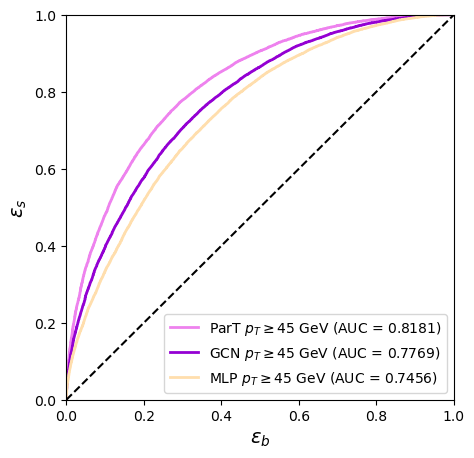

In [25]:
def plot_combined_roc_curves(data_dict):
    fig, ax = plt.subplots(figsize=(5,5))

    for model_name, (labels, predictions) in data_dict.items():
        # Compute ROC curve data
        fpr, tpr, thresholds = roc_curve(labels, predictions)
        roc_auc = roc_auc_score(labels, predictions)
        
        # Plot the ROC curve using the specified color and linestyle
        style = styles[model_name] 
        ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.4f})', color=style["color"], linestyle=style["linestyle"])
    # Plot random guess line
    ax.plot([0, 1], [0, 1], 'k--')

    # Set plot details
    ax.set_xlabel('$\epsilon_b$', fontsize=14)
    ax.set_ylabel('$\epsilon_s$', fontsize=14)
#     ax.set_title('ROC Curve for s-Quark vs d-Quark Jet Classification using GNN')
    ax.legend()
    ax.axis([0, 1, 0, 1])
#     ax.set_xlim(0,0.1)
#     ax.set_ylim(0,0.1)

    # Save the plot
    file_name = f'Combined_ROC_for_GNN_{suffix_1}'
    save_figure(plt, file_name)

    plt.show()


# Labels for the pie charts
if ss_dd_events:
    if suffix_1 == "200":
        styles = {
            "ParT $p_T \geq 200$ GeV": {"color": "deepskyblue", "linestyle": "-"},
            "GCN $p_T \geq 200$ GeV": {"color": "dodgerblue", "linestyle": "-"},
            "MLP $p_T \geq 200$ GeV": {"color": "darkcyan", "linestyle": "-"},
        }
    elif suffix_1 == "45":
        styles = {
            "ParT $p_T \geq 45$ GeV": {"color": "forestgreen", "linestyle": "-"},
            "GCN $p_T \geq 45$ GeV": {"color": "mediumspringgreen", "linestyle": "-"},
            "MLP $p_T \geq 45$ GeV": {"color": "mediumturquoise", "linestyle": "-"},
        }
elif bb_events:
    if suffix_1 == "200":
        styles = {
            "ParT $p_T \geq 200$ GeV": {"color": "crimson", "linestyle": "-"},
            "GCN $p_T \geq 200$ GeV": {"color": "darkorange", "linestyle": "-"},
            "MLP $p_T \geq 200$ GeV": {"color": "lightcoral", "linestyle": "-"},
        }
    elif suffix_1 == "45":
        styles = {
            "ParT $p_T \geq 45$ GeV": {"color": "violet", "linestyle": "-"},
            "GCN $p_T \geq 45$ GeV": {"color": "darkviolet", "linestyle": "-"},
            "MLP $p_T \geq 45$ GeV": {"color": "navajowhite", "linestyle": "-"},
        }


# Add more models/conditions as they become available
data_dict = {}
if suffix_1 == "200":
    data_dict.update({
        "ParT $p_T \geq 200$ GeV": (test_labels_ParT_200, predictions_ParT_200),
        "GCN $p_T \geq 200$ GeV": (test_labels_GCN_200, predictions_GCN_200),
        "MLP $p_T \geq 200$ GeV": (test_labels_MLP_200, predictions_MLP_200),
    })
elif suffix_1 == "45":
    data_dict.update({
        "ParT $p_T \geq 45$ GeV": (test_labels_ParT_45, predictions_ParT_45),
        "GCN $p_T \geq 45$ GeV": (test_labels_GCN_45, predictions_GCN_45),
        "MLP $p_T \geq 45$ GeV": (test_labels_MLP_45, predictions_MLP_45),
    })

plot_combined_roc_curves(data_dict)


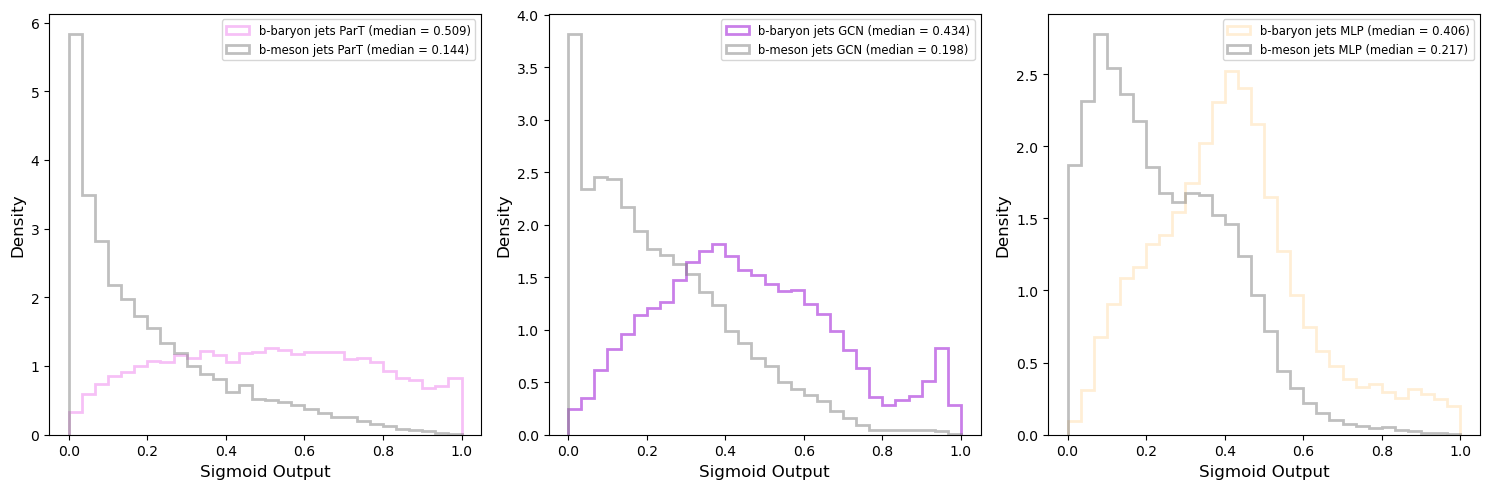

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

def plot_combined_sigmoid_output_distribution(data_dict, styles_sigmoid):
    # Determine the number of models to plot
    num_models = len(data_dict)
    fig, axs = plt.subplots(1, num_models, figsize=(5*num_models, 5))  # Adjust figure size as needed
    
    # If there's only one model, axs may not be iterable, so we ensure it's always a list
    if num_models == 1:
        axs = [axs]
    
    for ax, (model_name, (test_labels, predictions)) in zip(axs, data_dict.items()):
        # Separate sigmoid outputs based on their corresponding ground truth labels
        sigmoid_outputs_1 = predictions[test_labels == 1]
        sigmoid_outputs_0 = predictions[test_labels == 0]
        
        model_key = model_name.split("$")[0].strip()
        style = styles_sigmoid[model_key]

#         style = styles_sigmoid[model_name]
        
#         event_type = "s-Quark and d-Quark" if ss_dd_events else "b-Baryon and b-Meson"
        # Define the number of bins and their range for the histograms
        num_bins = 30
        bins = np.linspace(0, 1, num_bins + 1)
                             
        ax.hist(sigmoid_outputs_1, bins=bins, alpha=0.5, histtype='step', linewidth=2, label=f'{label_1_name} {model_key} (median = {np.median(sigmoid_outputs_1):.3f})', density=True, color=style["color"])
        ax.hist(sigmoid_outputs_0, bins=bins, alpha=0.5, histtype='step', linewidth=2, label=f'{label_0_name} {model_key} (median = {np.median(sigmoid_outputs_0):.3f})', density=True, color="grey")
        
        ax.set_xlabel("Sigmoid Output", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)
        ax.legend(loc='upper right', fontsize='small')
#         ax.set_title(f"Output Distribution: {model_name}")

    # Adjust the layout so that subplots are nicely fit into the figure area.
    plt.tight_layout()

    # Save the plot
    file_name = f'Combined_Sigmoid_Output_{suffix_1}'
    save_figure(plt, file_name)
    plt.show()

    
# Labels for the pie charts
if ss_dd_events:
    if suffix_1 == "200":
        styles_sigmoid = {
            "ParT": {"color": "deepskyblue", "linestyle": "-"},
            "GCN": {"color": "dodgerblue", "linestyle": "-"},
            "MLP": {"color": "darkcyan", "linestyle": "-"},
        }
    elif suffix_1 == "45":
        styles_sigmoid = {
            "ParT": {"color": "forestgreen", "linestyle": "-"},
            "GCN": {"color": "mediumspringgreen", "linestyle": "-"},
            "MLP": {"color": "mediumturquoise", "linestyle": "-"},
        }
elif bb_events:
    if suffix_1 == "200":
        styles_sigmoid = {
            "ParT": {"color": "crimson", "linestyle": "-"},
            "GCN": {"color": "darkorange", "linestyle": "-"},
            "MLP": {"color": "lightcoral", "linestyle": "-"},
        }
    elif suffix_1 == "45":
        styles_sigmoid = {
            "ParT": {"color": "violet", "linestyle": "-"},
            "GCN": {"color": "darkviolet", "linestyle": "-"},
            "MLP": {"color": "navajowhite", "linestyle": "-"},
        }
        
        
# Call the function with your data_dict
plot_combined_sigmoid_output_distribution(data_dict, styles_sigmoid)



# Optuna - Model Tuning

In [ ]:
if optuna_flag:
    def objective(trial):
        # Define hyperparameters using Optuna's suggest methods
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256, 512])
        hidden_feats_1 = trial.suggest_categorical("hidden_feats_1", [8, 16, 32, 64, 128])
        hidden_feats_2 = trial.suggest_categorical("hidden_feats_2", [8, 16, 32, 64, 128])
        hidden_feats_3 = trial.suggest_categorical("hidden_feats_3", [8, 16, 32, 64, 128])
        dropout_prob = trial.suggest_uniform("dropout_prob", 0, 0.5)
        num_feats = trial.suggest_categorical("num_feats", [2, 5, 8]) 

        # Add choices for optimizer
        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

        # Initialize the GNN model
        in_feats = num_node_features    

        # Create dataloaders with the suggested batch size
        train_dataloader = GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = GraphDataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_dataloader = GraphDataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        
        model = CustomGNN(in_feats, hidden_feats_1, hidden_feats_2, hidden_feats_3, dropout_prob)
        model = model.to(device)

        # Define loss function and optimizer
        loss_func = torch.nn.BCELoss() 

        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)



        train_losses = []
        val_losses = []

        epochs = 100

        for epoch in range(epochs):
            model.train()

            epoch_train_losses = []

            for batched_graph, batched_labels in train_dataloader:
                h = batched_graph.ndata['feat'].float().to(device)
                w = batched_graph.edata['weight'].float().to(device)
                batched_labels = batched_labels.view(-1, 1).to(device)

                # Performs a forward pass through the model using the current batch of data (graph, node features, and edge weights) and returns the output logits.
#                 logits = model(batched_graph, h, w)
                logits = model(batched_graph, h, w, num_feats)

                # calculates the loss using the model's output logits and the true labels for the current batch.
                loss = loss_func(logits, batched_labels) 


                epoch_train_losses.append(loss.item())

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_losses.append(np.mean(epoch_train_losses))

            model.eval()
            with torch.no_grad():

                epoch_val_losses = []

                for batched_graph, batch_labels in val_dataloader:
                    h = batched_graph.ndata['feat'].float().to(device)
                    w = batched_graph.edata['weight'].float().to(device)
                    batch_labels = batch_labels.view(-1, 1).to(device)


#                     logits = model(batched_graph, h, w)
                    logits = model(batched_graph, h, w, num_feats)
                    loss = loss_func(logits, batch_labels)


                    # Calculate validation accuracy
                    epoch_val_losses.append(loss.item())    

                val_losses.append(np.mean(epoch_val_losses))

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")


        # Return the last validation loss
        return val_losses[-1]

    # Create Optuna study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)


    # Save the best parameters and all trial information
    save_best_params(study)

    # Print study's best trial    
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best value (validation loss): {study.best_trial.value}")
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    print("All trials:")
    print(study.trials_dataframe())

# Data Analyze

## Graph Plot

In [32]:
def plot_graph(dgl_graph, node_color='deepskyblue', edge_dimension=0):
    plt.figure(figsize=(10, 10))
    G = nx.DiGraph()
    
    node_features = dgl_graph.ndata['feat'].numpy()
    edges = dgl_graph.edges()
    edge_weights = dgl_graph.edata['weight'][:, edge_dimension].numpy().flatten()

    jet_label = dgl_graph.glabel.item()
    
    identity_mapping = {
        0: {"shape": "o", "color": "crimson", "label": "Photon"},
        1: {"shape": "s", "color": "dodgerblue", "label": "Electron"},
        2: {"shape": "^", "color": "violet", "label": "Muon"},
        3: {"shape": "p", "color": "forestgreen", "label": "Charged Hadron"},
        4: {"shape": "D", "color": "orange", "label": "Neutral Hadron"},
        5: {"shape": "*", "color": "deepskyblue", "label": "$K_S$ or $\Lambda$"},
        6: {"shape": "X", "color": "gray", "label": "Padded Node"}
    }
    
    num_nodes = node_features.shape[0]
    non_zero_nodes = np.where(np.any(node_features, axis=1))[0]
    
    for i, nf in enumerate(node_features):
        nf = node_features[i] if i in non_zero_nodes else np.zeros(node_features.shape[1])
        G.add_node(i, features=nf)
    
    for i in range(edges[0].shape[0]):
        G.add_edge(edges[0][i].item(), edges[1][i].item(), weight=edge_weights[i])
    
#     pos = nx.circular_layout(G)
#     pos = nx.kamada_kawai_layout(G)
#     pos = nx.shell_layout(G)
    pos = nx.random_layout(G)
#     pos = nx.spring_layout(G)
    
    # Add nodes with different shapes and colors based on identity
    for identity, properties in identity_mapping.items():
        if identity != 6:
            identity_indices = [i for i, nf in enumerate(node_features) if nf[10:16][identity] != 0]
        else:
            identity_indices = [i for i in range(num_nodes) if i not in non_zero_nodes or np.all(node_features[i][10:19] == 0)]
        nx.draw_networkx_nodes(G, pos, nodelist=identity_indices, node_shape=properties["shape"], node_color=properties["color"], label=properties["label"])

        
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, width=2, alpha=0.5)
    nx.draw_networkx_labels(G, pos)

    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    # Define the jet type based on the jet label
    jet_type = "s-quark jet" if jet_label == 1 else "d-quark jet"

    plt.legend()
    plt.title(f"The Particles Within The {jet_type}")
    plt.axis('off')
    plt.show()

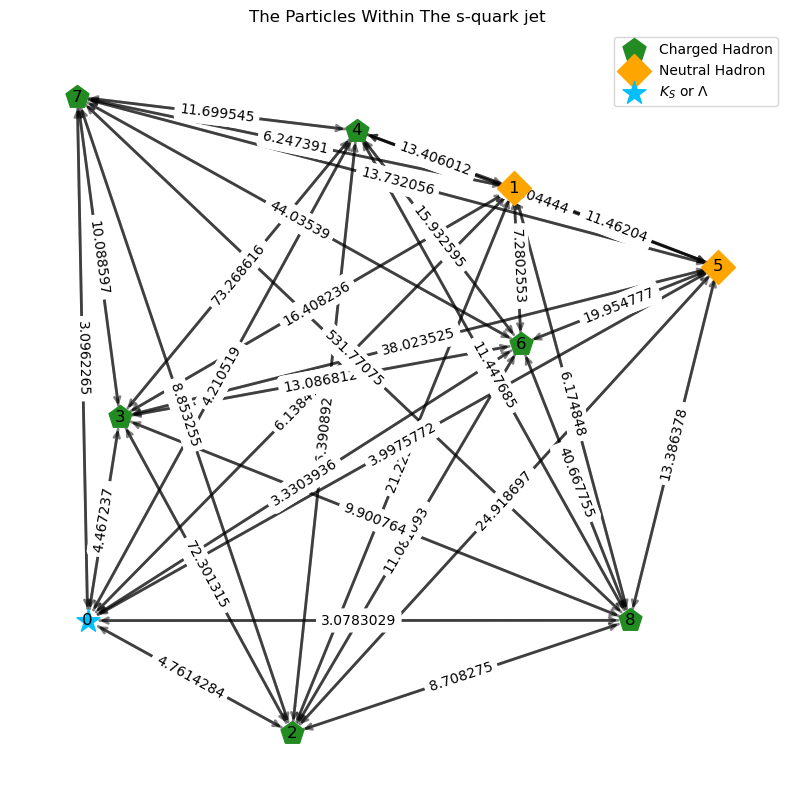

In [42]:
# Plot the a DGL graph as an example
plot_graph(dgl_graphs[3], edge_dimension=0)# edge_dimension could be equal 0,1,2

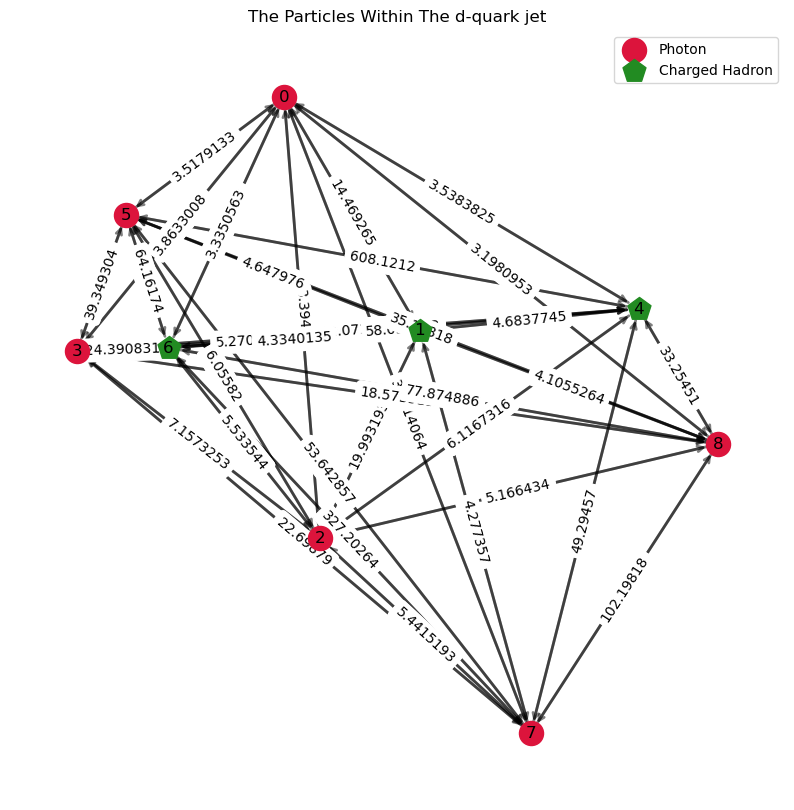

In [49]:
# Plot the a DGL graph as an example
plot_graph(dgl_graphs[7], edge_dimension=0)

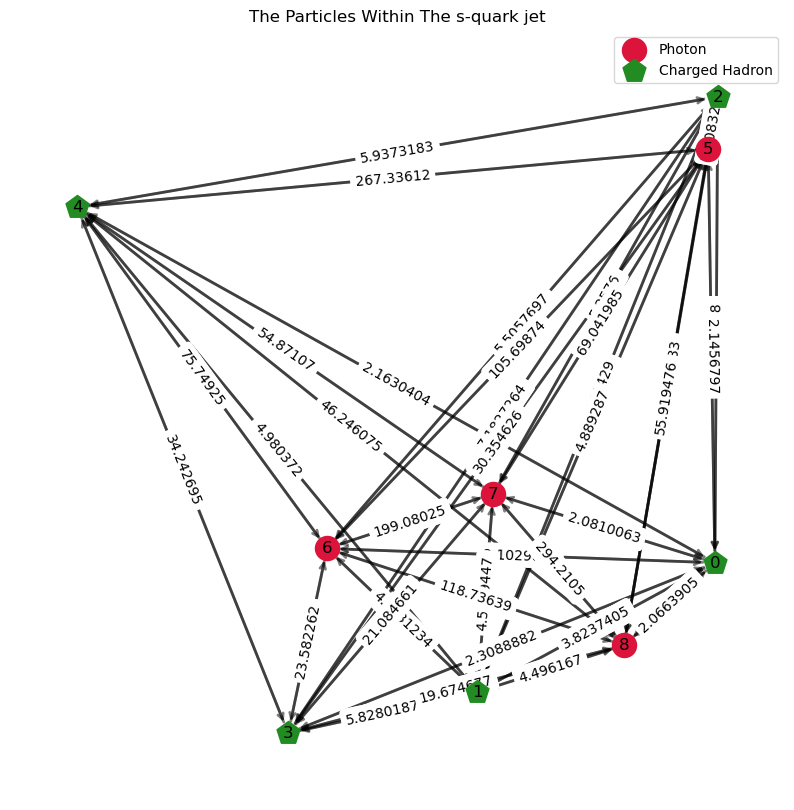

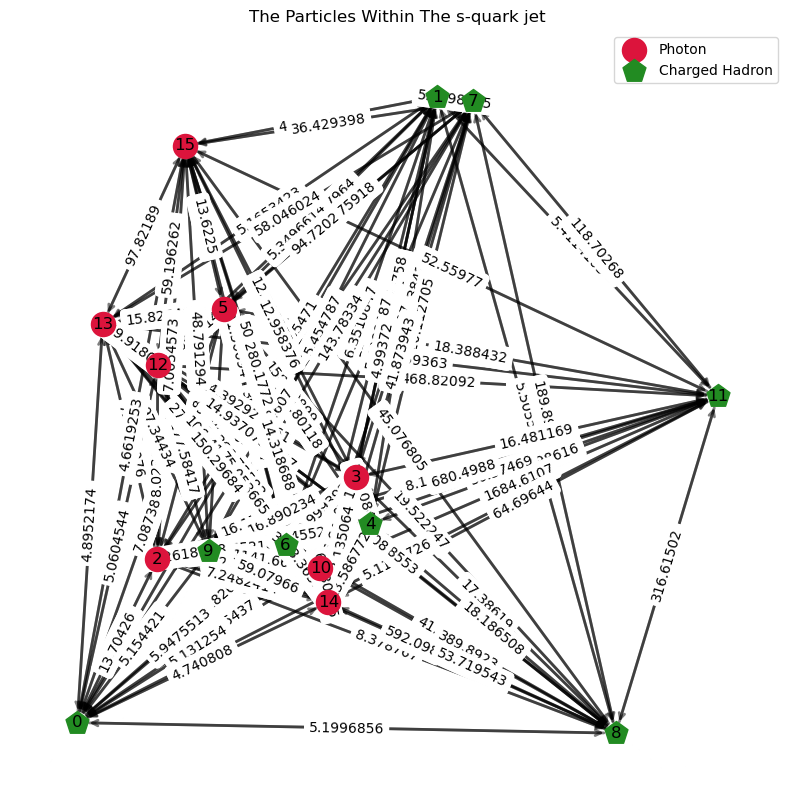

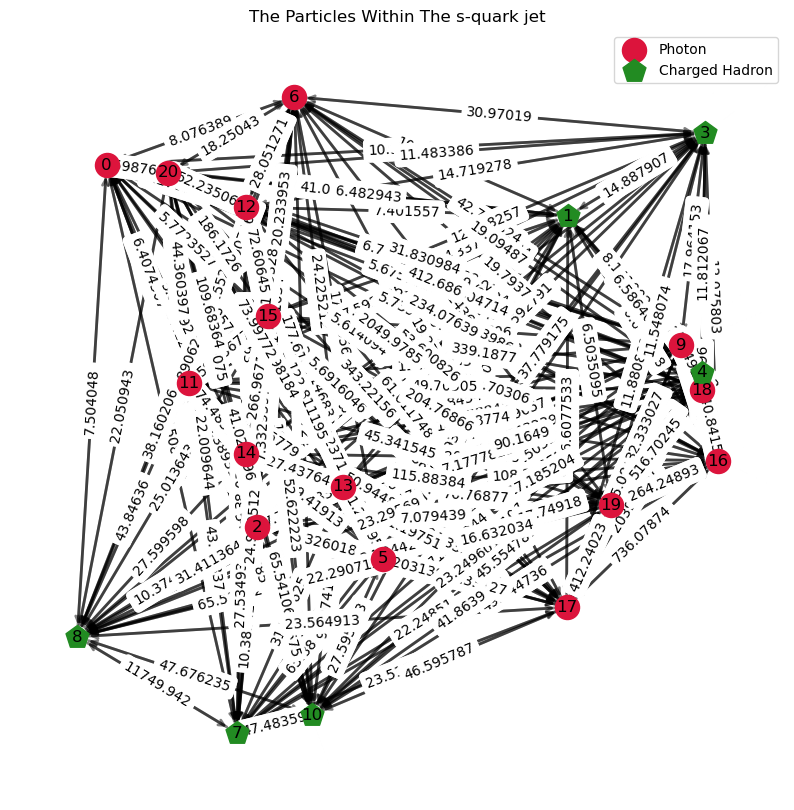

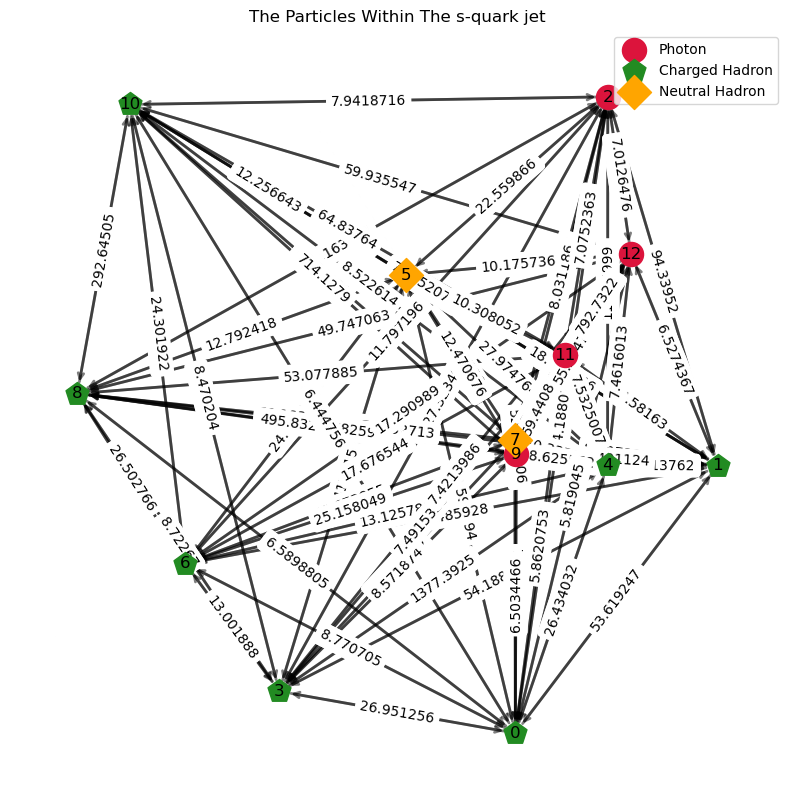

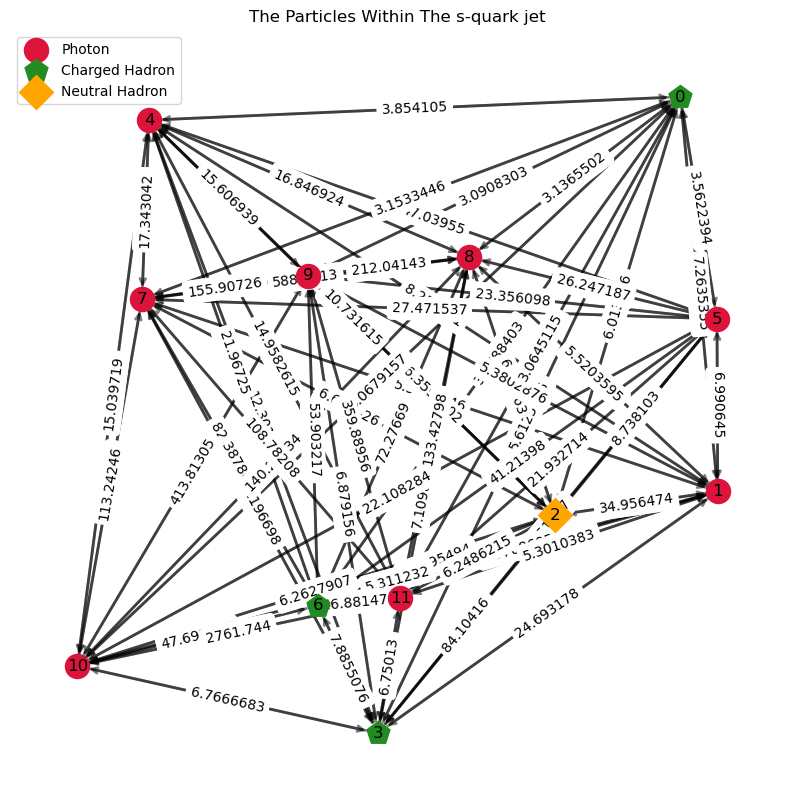

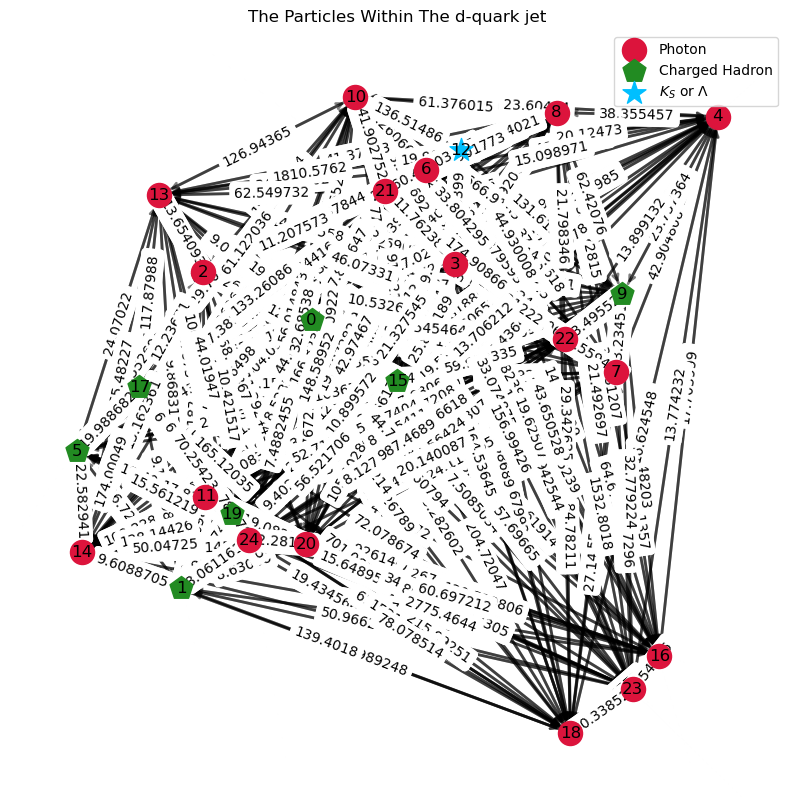

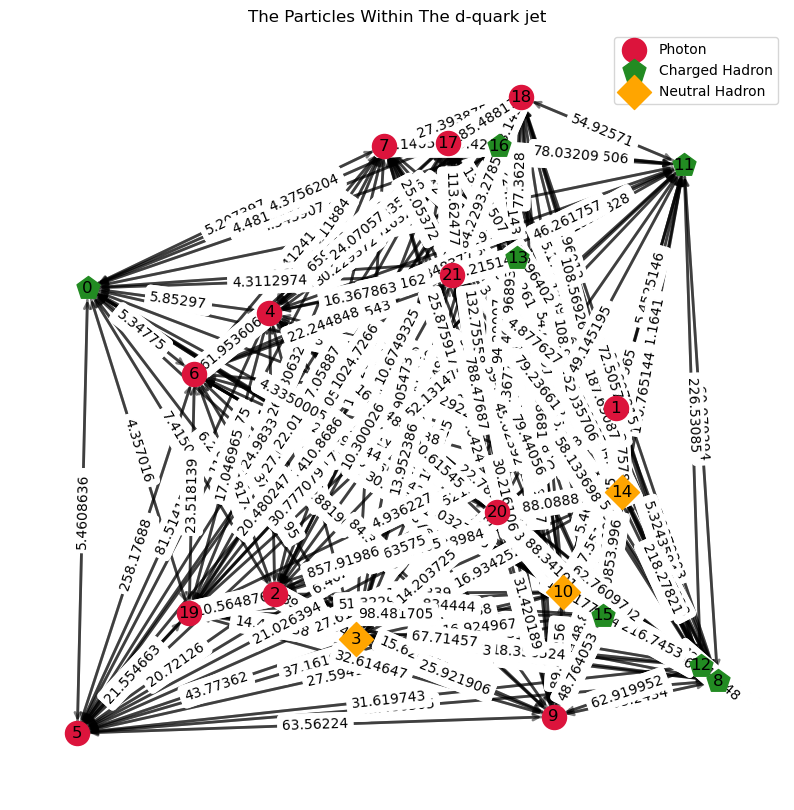

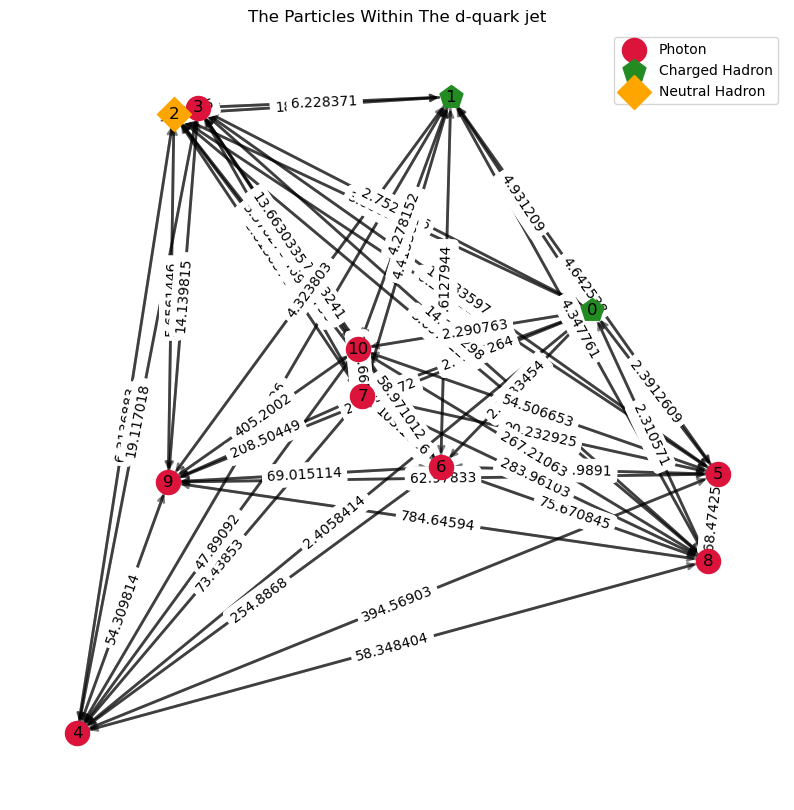

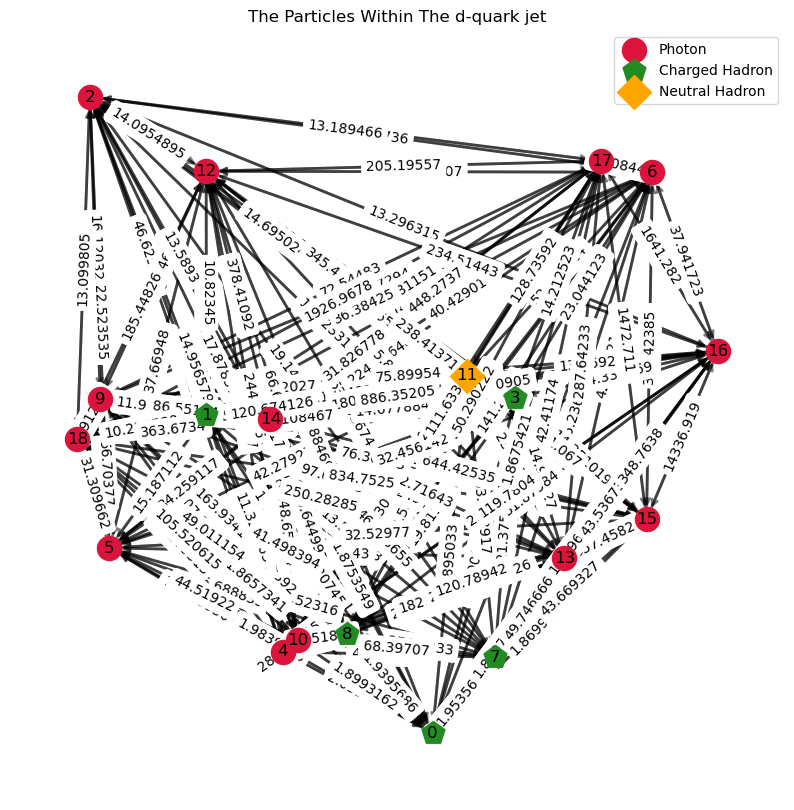

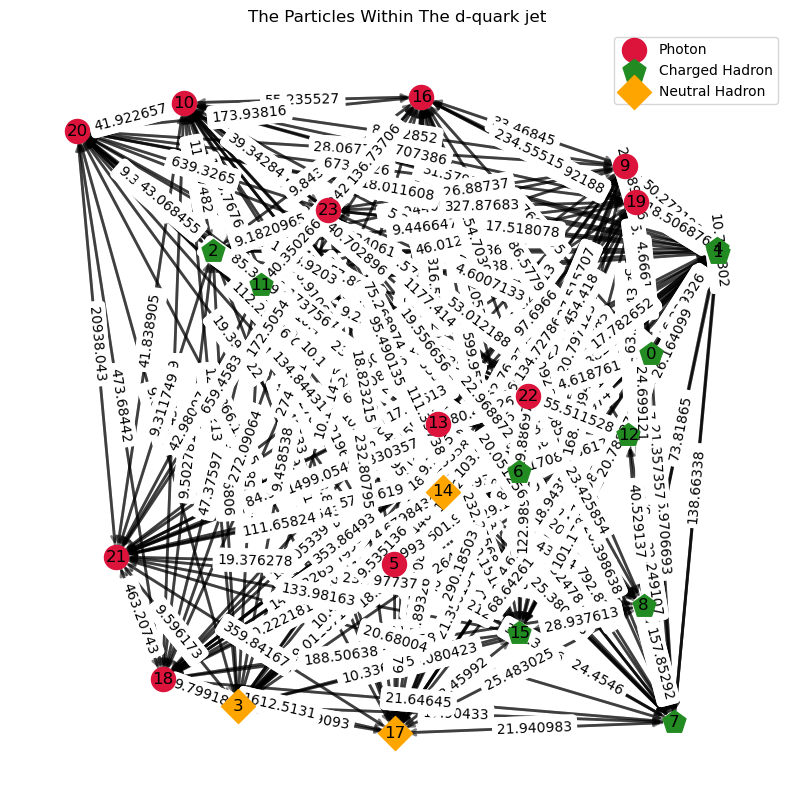

In [45]:
for i in range(10,20):
    plot_graph(dgl_graphs[i], edge_dimension=0)

## Histograms

In [ ]:
jets_pT_0 = [jets_pT[i] for i in range(len(all_data)) if all_data[i][-1] == 0]
jets_pT_1 = [jets_pT[i] for i in range(len(all_data)) if all_data[i][-1] == 1]

jet_eta_0 = [jet_eta[i] for i in range(len(all_data)) if all_data[i][-1] == 0]
jet_eta_1 = [jet_eta[i] for i in range(len(all_data)) if all_data[i][-1] == 1]

jets_constituents_number_0 = [jets_constituents_number[i] for i in range(len(all_data)) if all_data[i][-1] == 0]
jets_constituents_number_1 = [jets_constituents_number[i] for i in range(len(all_data)) if all_data[i][-1] == 1]

In [ ]:
def save_data_to_csv(data, filename, headers):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        writer.writerows(data)

# save_data_to_csv(zip(jets_pT_0, jets_pT_1), f'jets_pT_{suffix_1}.csv')
# save_data_to_csv(zip(jet_eta_0, jet_eta_1), f'jet_eta_{suffix_1}.csv')
# save_data_to_csv(zip(jets_constituents_number_0, jets_constituents_number_1), f'jets_constituents_number_{suffix_1}.csv')

if ss_dd_events:
    save_data_to_csv(zip(jets_pT_0, jets_pT_1), f's_jets_pT_{suffix_1}.csv', ['jets_pT_0', 'jets_pT_1'])
    save_data_to_csv(zip(jet_eta_0, jet_eta_1), f's_jet_eta_{suffix_1}.csv', ['jet_eta_0', 'jet_eta_1'])
    save_data_to_csv(zip(jets_constituents_number_0, jets_constituents_number_1), f's_jets_constituents_number_{suffix_1}.csv', ['jets_constituents_number_0', 'jets_constituents_number_1'])

elif bb_events:
    save_data_to_csv(zip(jets_pT_0, jets_pT_1), f'b_jets_pT_{suffix_1}.csv', ['jets_pT_0', 'jets_pT_1'])
    save_data_to_csv(zip(jet_eta_0, jet_eta_1), f'b_jet_eta_{suffix_1}.csv', ['jet_eta_0', 'jet_eta_1'])
    save_data_to_csv(zip(jets_constituents_number_0, jets_constituents_number_1), f'b_jets_constituents_number_{suffix_1}.csv', ['jets_constituents_number_0', 'jets_constituents_number_1'])


In [ ]:
def load_data_from_csv(filename):
    return pd.read_csv(filename)

if ss_dd_events:
    # Load data for 200 GeV
    data_200_pT = load_data_from_csv('s_jets_pT_200.csv')
    data_200_eta = load_data_from_csv('s_jet_eta_200.csv')
    data_200_constituents = load_data_from_csv('s_jets_constituents_number_200.csv')

    # Load data for 45 GeV
    data_45_pT = load_data_from_csv('s_jets_pT_45.csv')
    data_45_eta = load_data_from_csv('s_jet_eta_45.csv')
    data_45_constituents = load_data_from_csv('s_jets_constituents_number_45.csv')


if bb_events:
    # Load data for 200 GeV
    data_200_pT = load_data_from_csv('b_jets_pT_200.csv')
    data_200_eta = load_data_from_csv('b_jet_eta_200.csv')
    data_200_constituents = load_data_from_csv('b_jets_constituents_number_200.csv')

    # Load data for 45 GeV
    data_45_pT = load_data_from_csv('b_jets_pT_45.csv')
    data_45_eta = load_data_from_csv('b_jet_eta_45.csv')
    data_45_constituents = load_data_from_csv('b_jets_constituents_number_45.csv')

    
# Extract data for each jet type and energy level
jets_pT_0_200, jets_pT_1_200 = data_200_pT['jets_pT_0'], data_200_pT['jets_pT_1']
jets_pT_0_45, jets_pT_1_45 = data_45_pT['jets_pT_0'], data_45_pT['jets_pT_1']

jet_eta_0_200, jet_eta_1_200 = data_200_eta['jet_eta_0'], data_200_eta['jet_eta_1']
jet_eta_0_45, jet_eta_1_45 = data_45_eta['jet_eta_0'], data_45_eta['jet_eta_1']

jets_constituents_number_0_200, jets_constituents_number_1_200 = data_200_constituents['jets_constituents_number_0'], data_200_constituents['jets_constituents_number_1']
jets_constituents_number_0_45, jets_constituents_number_1_45 = data_45_constituents['jets_constituents_number_0'], data_45_constituents['jets_constituents_number_1']

In [ ]:
print("d-jets:", "mean:", np.mean(jets_pT_0), "median:", np.median(jets_pT_0), "std:", np.std(jets_pT_0))
print("s-jets:","mean:", np.mean(jets_pT_1), "median:", np.median(jets_pT_1), "std:", np.std(jets_pT_1))

print("d-jets:", "mean:", np.mean(jet_eta_0), "median:", np.median(jet_eta_0), "std:", np.std(jet_eta_0))
print("s-jets:","mean:", np.mean(jet_eta_1), "median:", np.median(jet_eta_1), "std:", np.std(jet_eta_1))

print("d-jets:", "mean:", np.mean(jets_constituents_number_0), "median:", np.median(jets_constituents_number_0), "std:", np.std(jets_constituents_number_0))
print("s-jets:", "mean:", np.mean(jets_constituents_number_1), "median:", np.median(jets_constituents_number_1), "std:", np.std(jets_constituents_number_1))

In [ ]:
if ss_dd_events:
    label_0_name = 'd-quark jets'
    label_1_name = 's-quark jets'
elif bb_events:
    label_0_name = 'b-meson jets'
    label_1_name = 'b-baryon jets'

In [ ]:
# Ensure the directory exists, if not, create it.
if not os.path.exists('s_tagger_figs'):
    os.makedirs('s_tagger_figs')

def Hist(label_0, label_1, title, file_name, x_label, y_label, num_bins, x_limits=None, y_limits=None):
    plt.figure(figsize=(10, 6))  # Create a new figure and specify its size
    
    median_label_0 = np.median(label_0)  # Compute the median of label_0 data
    median_label_1 = np.median(label_1)  # Compute the median of label_1 data
    
    # Determine the overall min and max of the data to set the bins.
    overall_min = min(min(label_0), min(label_1))
    overall_max = max(max(label_0), max(label_1))
    
    if title == 'Number of Jet Constituents Distribution':
        bins = np.arange(overall_min-0.5, overall_max+1.5)
    else:
        bins = np.linspace(overall_min, overall_max, num_bins + 1)

    # Incorporate the median into the label text
#     plt.hist(label_0, bins=bins, color='deepskyblue', alpha=0.5, density=True, label=f'd-quark jets = {median_label_0:.2f}')
#     plt.hist(label_1, bins=bins, color='crimson', alpha=0.5, density=True, label=f's-quark jets = {median_label_1:.2f}')
    
    plt.hist(label_0, bins=bins, color='deepskyblue', histtype='step', linewidth=2, density=True, label=f'{label_0_name} = {median_label_0:.2f}')
    plt.hist(label_1, bins=bins, color='crimson', histtype='step', linewidth=2, density=True, label=f'{label_1_name} = {median_label_1:.2f}')
    
             
    plt.title(title, fontsize=16)  # Set the title for the histogram with larger font size
    plt.xlabel(x_label, fontsize=14)  # Set x-axis label with specified font size
    plt.ylabel(y_label, fontsize=14)  # Set y-axis label with specified font size
    plt.legend(fontsize=12)  # Add a legend to the histogram with larger font size
    
    plt.xticks(fontsize=12)  # Increase x-axis tick font size
    plt.yticks(fontsize=12)  # Increase y-axis tick font size
    
    if x_limits:
        plt.xlim(x_limits)  # Set x-axis limits

    if y_limits:
        plt.ylim(y_limits)  # Set y-axis limits
    
    
#     save_figure(plt, file_name)
    plt.show()

if pc_file_flag_200 or cluster_file_flag_200:
    Hist(jets_pT_0, jets_pT_1, 'Jets Transverse Momentum Distribution', f'Jets_pT_Distribution_{suffix_1}', '$p_T$ [GeV/c]', 'Normalized Count', 50, x_limits=(150, 700))
    Hist(jet_eta_0, jet_eta_1, 'Jets Pseudorapidity Distribution', f'Jet_eta_Distribution_{suffix_1}', '$\eta$', 'Normalized Count', 50, x_limits=(-1.5, 1.5))
    Hist(jets_constituents_number_0, jets_constituents_number_1, 'Number of Jet Constituents Distribution', f'Jet_Constituents_Number_Distribution_{suffix_1}', 'Number of Constituents', 'Normalized Count', 50, x_limits=(-10, 80))

    
elif pc_file_flag_45 or cluster_file_flag_45:
    Hist(jets_pT_0, jets_pT_1, 'Jets Transverse Momentum Distribution', f'Jets_pT_Distribution_{suffix_1}', '$p_T$ [GeV/c]', 'Normalized Count', 80, x_limits=(0, 300))
    Hist(jet_eta_0, jet_eta_1, 'Jets Pseudorapidity Distribution', f'Jet_eta_Distribution_{suffix_1}', '$\eta$', 'Normalized Count', 80, x_limits=(-1.5, 1.5))
    Hist(jets_constituents_number_0, jets_constituents_number_1, 'Number of Jet Constituents Distribution', f'Jet_Constituents_Number_Distribution_{suffix_1}', 'Number of Constituents', 'Normalized Count', 80, x_limits=(-10, 80))

    


In [ ]:

def Hist(label_0_200, label_1_200, label_0_45, label_1_45, title, file_name, x_label, y_label, num_bins, x_limits=None, y_limits=None):
    plt.figure(figsize=(10, 6))

    # Compute medians
    median_label_0_200 = np.median(label_0_200)
    median_label_1_200 = np.median(label_1_200)
    median_label_0_45 = np.median(label_0_45)
    median_label_1_45 = np.median(label_1_45)

    
    # Determine bins
    overall_max = max(max(label_0_200), max(label_1_200), max(label_0_45), max(label_1_45))

    # For the pt histogram, ensure bins start at 200 for the 200 GeV data
    if title == 'Jets Transverse Momentum Distribution':
        bins_200 = np.linspace(200, overall_max, num_bins + 1)
        # Start at the minimum of the 45 GeV data for its binning
        min_45 = min(min(label_0_45), min(label_1_45))
        bins_45 = np.linspace(min_45, overall_max, num_bins + 1)

    # For the number of constituents, use integer bin edges
    elif title == 'Number of Jet Constituents Distribution':
        # Find the minimum value for 45 GeV data as it will have the smaller numbers
        min_const = min(min(jets_constituents_number_0_45), min(jets_constituents_number_1_45))
        max_const = overall_max  # Use the overall max for the upper limit
        bins_const = np.arange(min_const - 0.5, max_const + 1.5, 1)  # Step size of 1 for integer values
        bins_200 = bins_45 = bins_const  # Use the same bins for 200 GeV and 45 GeV data

    # For other histograms, use common binning
    else:
        overall_min = min(min(label_0_200), min(label_1_200), min(label_0_45), min(label_1_45))
        bins = np.linspace(overall_min, overall_max, num_bins + 1)
        bins_200 = bins_45 = bins  # Use the same bins for both

        
    # Plot histograms
    if ss_dd_events:
        plt.hist(label_0_200, bins=bins_200, color='dodgerblue', histtype='step', linewidth=2, density=True, label=f'{label_0_name} ($p_T \geq 200$ GeV) = {median_label_0_200:.2f}', alpha=0.7)
        plt.hist(label_1_200, bins=bins_200, color='deepskyblue', histtype='step', linewidth=2, density=True, label=f'{label_1_name} ($p_T \geq 200$ GeV) = {median_label_1_200:.2f}', alpha=0.7)
        plt.hist(label_0_45, bins=bins_45, color='forestgreen', histtype='step', linewidth=2, density=True, label=f'{label_0_name} ($p_T \geq 45$ GeV) = {median_label_0_45:.2f}', alpha=0.7)
        plt.hist(label_1_45, bins=bins_45, color='mediumspringgreen', histtype='step', linewidth=2, density=True, label=f'{label_1_name} ($p_T \geq 45$ GeV) = {median_label_1_45:.2f}', alpha=0.7)
    elif bb_events:
        plt.hist(label_0_200, bins=bins_200, color='crimson', histtype='step', linewidth=2, density=True, label=f'{label_0_name} ($p_T \geq 200$ GeV) = {median_label_0_200:.2f}', alpha=0.7)
        plt.hist(label_1_200, bins=bins_200, color='darkorange', histtype='step', linewidth=2, density=True, label=f'{label_1_name} ($p_T \geq 200$ GeV) = {median_label_1_200:.2f}', alpha=0.7)
        plt.hist(label_0_45, bins=bins_45, color='darkviolet', histtype='step', linewidth=2, density=True, label=f'{label_0_name} ($p_T \geq 45$ GeV) = {median_label_0_45:.2f}', alpha=0.7)
        plt.hist(label_1_45, bins=bins_45, color='violet', histtype='step', linewidth=2, density=True, label=f'{label_1_name} ($p_T \geq 45$ GeV) = {median_label_1_45:.2f}', alpha=0.7)
    
#     plt.hist(label_0_45, bins=bins_45, color='crimson', histtype='step', linewidth=2, density=True, label=f'd-quark jets ($p_T \geq 45$ GeV) = {median_label_0_45:.2f}', alpha=0.7)
#     plt.hist(label_1_45, bins=bins_45, color='lightpink', histtype='step', linewidth=2, density=True, label=f's-quark jets ($p_T \geq 45$ GeV) = {median_label_1_45:.2f}', alpha=0.7)

    # Set plot details|
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    
    if x_limits: plt.xlim(x_limits)
    if y_limits: plt.ylim(y_limits)

    # Save and show figure
    save_figure(plt, file_name)
    plt.show()

    
# Plot histograms for jets' transverse momentum
Hist(jets_pT_0_200, jets_pT_1_200, jets_pT_0_45, jets_pT_1_45, 'Jets Transverse Momentum Distribution', 'Jets_pT_Distribution', '$p_T$ [GeV/c]', 'Normalized Count', 80, x_limits=(0, 700))

# Plot histograms for jets' pseudorapidity
Hist(jet_eta_0_200, jet_eta_1_200, jet_eta_0_45, jet_eta_1_45, 'Jets Pseudorapidity Distribution', 'Jet_eta_Distribution', '$\eta$', 'Normalized Count', 80, x_limits=(-1.5, 1.5))

# Plot histograms for number of jet constituents
Hist(jets_constituents_number_0_200, jets_constituents_number_1_200, jets_constituents_number_0_45, jets_constituents_number_1_45, 'Number of Jet Constituents Distribution', 'Jet_Constituents_Number_Distribution', 'Number of Constituents', 'Normalized Count', 50, x_limits=(-10, 80))

In [ ]:
# all_data_0 = all_data[all_data[:, -1] == 0]
# all_data_1 = all_data[all_data[:, -1] == 1]

all_data_0 = [row for row in all_data if row[-1] == 0]
all_data_1 = [row for row in all_data if row[-1] == 1]
print("the number of with: label 0:", len(all_data_0), "label 1:" , len(all_data_1))
# print("label 0 shape:", all_data_0.shape, "lable 1 shape:", all_data_1.shape)

In [ ]:
# Highest pT Particle
# particle_data_0 = all_data_0[:, 3:9]
# particle_data_1 = all_data_1[:, 3:9]


# Highest pT Particle
particle_data_0 = [row[10:16] for row in all_data_0]
particle_data_1 = [row[10:16] for row in all_data_1]


# convert these lists of sublists into arrays
particle_data_0 = np.array(particle_data_0)
particle_data_1 = np.array(particle_data_1)

print(particle_data_1)



In [ ]:
def count_particles(particle_data):
#     particles_count = np.zeros(10)

#     for row in particle_data:
#         if row[0] == 1:
#             particles_count[0] += 1
#         elif row[1] == 1:
#             particles_count[1] += 1
#         elif row[1] == -1:
#             particles_count[2] += 1
#         elif row[2] == 1:
#             particles_count[3] += 1
#         elif row[2] == -1:
#             particles_count[4] += 1
#         elif row[3] == 1:
#             particles_count[5] += 1
#         elif row[3] == -1:
#             particles_count[6] += 1
#         elif row[4] == 1:
#             particles_count[7] += 1
#         elif row[5] == 1:
#             particles_count[8] += 1
#         elif row[5] == -1:
#             particles_count[9] += 1
    
#     if ss_dd_events:
    particles_count = np.zeros(8)               
    for row in particle_data:
        if row[0] == 1:
            particles_count[0] += 1
        elif row[1] == 1 or row[1] == -1:
            particles_count[1] += 1
        elif row[2] == 1 or row[2] == -1:
            particles_count[2] += 1
        elif row[3] == 1:
            particles_count[3] += 1
        elif row[3] == -1:
            particles_count[4] += 1
        elif row[4] == 1:
            particles_count[5] += 1
        elif row[5] == -1:
            particles_count[6] += 1
        elif row[5] == 1:
            particles_count[7] += 1
    print(particles_count)

#     if bb_events:
#         particles_count = np.zeros(7)               
#         for row in particle_data:
#             if row[0] == 1:
#                 particles_count[0] += 1
#             elif row[1] == 1 or row[1] == -1:
#                 particles_count[1] += 1
#             elif row[2] == 1 or row[2] == -1:
#                 particles_count[2] += 1
#             elif row[3] == 1:
#                 particles_count[3] += 1
#             elif row[3] == -1:
#                 particles_count[4] += 1
#             elif row[4] == 1:
#                 particles_count[5] += 1
#             elif row[5] == 1:
#                 particles_count[6] += 1
#         print(particles_count)

    # Normalize the particle counts
    particles_count = (particles_count / len(particle_data)) * 100
            
    return particles_count

def plot_histogram(particle_counts_0, particle_counts_1, file_name): # The \n is for line space
#     particles = ['$\gamma$', '$e^-$', '$e^+$', '$\mu^-$', '$\mu^+$', '$\pi^+, p^+, K^+$', '$\pi^-, p^-, K^-$', '$n, K_L$', '$K_S$', '$\Lambda$']
#     particles = ['$\gamma$', '$e^-$', '$e^+$', '$\mu^-$', '$\mu^+$', 'Positive Charged Hadrons', 'Negative Charged Hadrons', 'Neutral Hadrons', '$K_S$', '$\Lambda$']
#     particles = ['$\gamma$', '$e^-$', '$e^+$', '$\mu^-$', '$\mu^+$', 'Positive\nCharged\nHadrons', 'Negative\nCharged\nHadrons', 'Neutral\nHadrons', '$K_S$', '$\Lambda$']
    

    particles = ['$\gamma$', '$e^-, e^+$', '$\mu^-, \mu^+$', 'Positive\nCharged\nHadrons', 'Negative\nCharged\nHadrons', 'Neutral\nHadrons', '$K_S$', '$\Lambda$']

    

    x = np.arange(len(particles)) 
    
    width = 0.3
    fig, ax = plt.subplots(figsize=(6, 5))
    if ss_dd_events:
        hist1 = ax.bar(x - width/2, particle_counts_0, width, label=f'{label_0_name}', color = 'deepskyblue', alpha = 0.8)
        hist2 = ax.bar(x + width/2, particle_counts_1, width, label=f'{label_1_name}', color = 'forestgreen', alpha = 0.8)
    elif bb_events:
        hist1 = ax.bar(x - width/2, particle_counts_0, width, label=f'{label_0_name}', color = 'darkorange', alpha = 0.8)
        hist2 = ax.bar(x + width/2, particle_counts_1, width, label=f'{label_1_name}', color = 'darkviolet', alpha = 0.8)
    ax.set_ylabel('Proportion (%)')
#     ax.set_title(f'Distribution of the Highest $p_T$ Particle Types in s-quark and d-quark Jets ($p_T \geq {suffix_1}$ GeV)')
    ax.set_xticks(x)
#     ax.set_xticklabels(particles, rotation=90)
    ax.set_xticklabels(particles)

    ax.legend(loc = 'upper left')

     # Add numbers to the bars
    for bar in hist1:
        height = bar.get_height()
        ax.annotate('{:.1f}%'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 8), textcoords="offset points", ha='center', va='bottom')

    for bar in hist2:
        height = bar.get_height()
        ax.annotate('{:.1f}%'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 9), textcoords="offset points", ha='center', va='bottom')
        
#     # Add numbers to the bars
#     for bar in hist1:
#         height = bar.get_height()
#         ax.annotate('{}'.format(int(height)), xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

#     for bar in hist2:
#         height = bar.get_height()
#         ax.annotate('{}'.format(int(height)), xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 8), textcoords="offset points", ha='center', va='bottom')
        
    
    fig.tight_layout()
    if bb_events:
        plt.ylim(0,48)
    else:
        plt.ylim(0,45)
    
    save_figure(plt, file_name)
    plt.show()

    
particle_counts_0 = count_particles(particle_data_0)
particle_counts_1 = count_particles(particle_data_1)
plot_histogram(particle_counts_0, particle_counts_1, f'Highest pT particle Count Histogram_{suffix_1}')



# particle_counts_0_200 = count_particles(particle_data_0_200)
# particle_counts_1_200 = count_particles(particle_data_1_200)
# particle_counts_0_45 = count_particles(particle_data_0_45)
# particle_counts_1_45 = count_particles(particle_data_1_45)


# # Plot histograms for 200 GeV data
# plot_histogram(particle_counts_0_200, particle_counts_1_200, 'Highest pT particle Count Histogram_200')
# # Plot histograms for 45 GeV data
# plot_histogram(particle_counts_0_45, particle_counts_1_45, 'Highest pT particle Count Histogram_45')

## Pie Charts

In [ ]:

# Separate the jet_energy based on labels
jet_energy_0 = [jet_energy[i] for i in range(len(all_data)) if all_data[i][-1] == 0]
jet_energy_1 = [jet_energy[i] for i in range(len(all_data)) if all_data[i][-1] == 1]


# Convert to NumPy arrays for easier manipulation
jet_energy_0_array = np.array(jet_energy_0)
jet_energy_1_array = np.array(jet_energy_1)

# Rearranging columns: 'Photon', 'Lambda', 'Charged Hadron', 'Muon', 'Electron', 'Neutral Hadron', 'Ks'
jet_energy_0_array = jet_energy_0_array[:, [0, 6, 3, 2, 1, 4, 5]]
# print(jet_energy_0_array)
jet_energy_1_array = jet_energy_1_array[:, [0, 6, 3, 2, 1, 4, 5]]


# Calculate the median for each component
mean_energy_0 = np.mean(jet_energy_0_array, axis=0)
mean_energy_1 = np.mean(jet_energy_1_array, axis=0)

# colors = ['crimson', 'forestgreen', 'deepskyblue', 'violet', 'orange', 'pink']

# Labels for the pie charts
if ss_dd_events:
    # Define colors
    colors = ['forestgreen', 'lightgreen', 'deepskyblue', 'lightgreen', 'mediumturquoise', 'darkcyan', 'dodgerblue']
    labels = ['Photon', '$\Lambda$', 'Charged Hadron', 'Muon', 'Electron', 'Neutral Hadron', '$K_S$']
if bb_events:
    colors = ['violet', 'navajowhite', 'crimson', 'lightcoral', 'darkorange', 'pink', 'deeppink']
    labels = ['Photon', '$\Lambda$', 'Charged Hadron', 'Muon', 'Electron', 'Neutral Hadron', '$K_S$']

# Define explode to slightly separate the photon contribution
explode = [0.1, 0.1, 0.1, 0.07, 0.2, 0.1, 0.1]


fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Title for the entire figure
# fig.suptitle(f'Distribution of the Energy for Each Jet ($p_T \geq {suffix_1}$ GeV)', fontsize=18)

# d-quark jets
axs[0].pie(mean_energy_0, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14}, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}, explode=explode)
axs[0].set_title(f'{label_0_name}', fontsize=16)

# s-quark jets
axs[1].pie(mean_energy_1, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14}, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}, explode=explode)
axs[1].set_title(f'{label_1_name}', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjusts subplot layout to fit better

file_name = f'Energy pie chart {suffix_1}'
save_figure(plt, file_name)

plt.show()


## KS or Lambda Proportion 

In [ ]:
def calculate_average_proportions(all_data):
    # Initial counts
    s_jet_proportions = {'KS': 0, 'Lambda': 0}
    d_jet_proportions = {'KS': 0, 'Lambda': 0}
    s_jet_count = 0
    d_jet_count = 0

    for jet in all_data:
        # Identify jet type
        jet_type = 's' if jet[-1] == 1 else 'd'

        # Counters for current jet's KS, Lambda, and total constituents
        ks_count = 0
        lambda_count = 0
        total_constituents = 0

        # Loop through constituents
        for i in range(10, len(jet) - 1, 9):
            classification_value = jet[i + 5]
            if classification_value == -1:
                ks_count += 1
            elif classification_value == 1:
                lambda_count += 1
            total_constituents += 1

        # Update the total and KS, Lambda proportions for the jet type
        if jet_type == 's':
            s_jet_proportions['KS'] += ks_count / total_constituents
            s_jet_proportions['Lambda'] += lambda_count / total_constituents
            s_jet_count += 1
        else:
            d_jet_proportions['KS'] += ks_count / total_constituents
            d_jet_proportions['Lambda'] += lambda_count / total_constituents
            d_jet_count += 1

    # Calculate average proportions
    s_jet_proportions['KS'] /= s_jet_count
    s_jet_proportions['Lambda'] /= s_jet_count

    d_jet_proportions['KS'] /= d_jet_count
    d_jet_proportions['Lambda'] /= d_jet_count

    return s_jet_proportions, d_jet_proportions

s_proportions, d_proportions = calculate_average_proportions(all_data)

print("Average Proportions for s-jets:")
print(f"KS: {100 * s_proportions['KS']:.2f}%")
print(f"Lambda: {100 * s_proportions['Lambda']:.2f}%")
print("----")
print("Average Proportions for d-jets:")
print(f"KS: {100 * d_proportions['KS']:.2f}%")
print(f"Lambda: {100 * d_proportions['Lambda']:.2f}%")


In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['$K_S$', '$\Lambda$']
s_jet_values = [100 * s_proportions['KS'], 100 * s_proportions['Lambda']]
d_jet_values = [100 * d_proportions['KS'], 100 * d_proportions['Lambda']]
bar_width = 0.35  # width of the bars
index = range(len(labels))  # label locations

# Bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(index, s_jet_values, bar_width, label='s-jets', color='deepskyblue', alpha=0.7)
bar2 = ax.bar([i + bar_width for i in index], d_jet_values, bar_width, label='d-jets', color='crimson', alpha=0.7)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Particle Type')
ax.set_ylabel('Proportions (%)')
ax.set_title('Average Proportions for s-jets and d-jets')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(labels)
ax.legend()

plt.show()


## Prediciting the model using ROC

In [ ]:
# Use a copy of all_data for processing
all_data_processed = all_data.copy()

# Define constants
if no_energy:
    jet_features = 3 # pT, eta, Number of constituents
else:
    jet_features = 10 # pT, eta, Number of constituents and 7 for the total energies

constituent_features = 9 # 6 for identity, rel_pT, r, alpha

# max_constituents = max((len(row) - jet_features - 1) // constituent_features for row in all_data)
max_constituents = 30
total_length = jet_features + (constituent_features * max_constituents) + 1

# Adjust each list accordingly
# for i in range(len(all_data_processed)):
for i in tqdm(range(len(all_data_processed)), desc="Processing data"):
    # Separate out the jet features, constituents, and label
    jet = all_data_processed[i][:jet_features]
    constituents = all_data_processed[i][jet_features:-1]
    label = [all_data_processed[i][-1]]

    # If there are more than 10 constituents, trim the list
    constituents = constituents[:max_constituents * constituent_features]

    # If there are fewer than 10 constituents, pad with NaNs
    # Calculate the number of padding elements needed
    padding_needed = max_constituents * constituent_features - len(constituents)
    # Pad with NaNs if required
    for j in range(padding_needed):
        constituents.append(np.nan)


    # Construct the adjusted row and replace the original row with it
    all_data_processed[i] = jet + constituents + label

# Convert the adjusted data to a DataFrame
all_data_table = pd.DataFrame(all_data_processed)
all_data_table


### ROC For Most Discriminative Jet Features

In [ ]:
def plot_roc_curves(df, title, file_name, limit=None):
    # Get the target column index
    label = df.columns[-1]

    # Get the feature columns
    columns = df.columns[:-1]
    
#     if ss_dd_events:
#         roc_label_energy_name = 'Ks or Lambda Energy'
#         roc_label_name = 'Ks or Lambda'
#     elif bb_events:
#         roc_label_energy_name = 'Lambda Energy'
#         roc_label_name = 'Lambda'
        
    # Define custom labels for the columns
    custom_labels = {0: 'Jet $p_T$', 1: 'Jet $\eta$', 2: 'Number of Jet Constituents', 3: 'Photon Energy', 4: 'Electron Energy', 5: 'Muon Energy', 6: 'Charged Hadron Energy', 7: 'Neutral Hadron Energy', 8: '$K_S$ energy', 9: '$\Lambda$ energy'}
#     custom_labels = {0: 'Jet $p_T$', 1: 'Jet $\eta$', 2: 'Number of Jet Constituents', 3: 'Photon Energy', 4: 'Electron Energy', 5: 'Muon Energy', 6: 'Charged Hadron Energy', 7: 'Neutral Hadron Energy', 8: f'{roc_label_energy_name}'}
    
    
    num_constituents = (len(columns) - jet_features) // constituent_features
    for i in range(num_constituents):
        index = jet_features + constituent_features*i
        # The first 6 indices are the 'i' particle label
        custom_labels[index] = f'Particle {i}: Photon'
        custom_labels[index+1] = f'Particle {i}: Electron'
        custom_labels[index+2] = f'Particle {i}: Muon'   
        custom_labels[index+3] = f'Particle {i}: Charged Hadron'
        custom_labels[index+4] = f'Particle {i}: Neutral Hadron'
        custom_labels[index+5] = f'Particle {i}: $K_S$ or $\Lambda$'
#         custom_labels[index+5] = f'Particle {i}: {roc_label_name}'
        
        # The last 3 indices are the 'i' particle features
        custom_labels[index+6] = f'Particle {i}: $p_T$'
        custom_labels[index+7] = f'Particle {i}: $r$'
        custom_labels[index+8] = f'Particle {i}: $\\alpha$'

    # Initialize a dictionary to store the ROC AUC scores for each column
    roc_auc_scores = {}

    # Compute ROC AUC for each column
    for col in columns:
        # Filter rows where the current column contains NaN values
        valid_idx = df[col].notna()

        # Compute the TPR and FPR for the filtered rows
        fpr, tpr, thresholds = roc_curve(df[label][valid_idx], df[col][valid_idx])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores[col] = roc_auc


    # Convert the dictionary to a pandas DataFrame
    roc_auc_scores_df = pd.DataFrame.from_dict(roc_auc_scores, orient='index', columns=['AUC'])

    # Create a new column for the absolute distance from 0.5
    roc_auc_scores_df['Abs Distance'] = (roc_auc_scores_df['AUC'] - 0.5).abs()

    # Sort the DataFrame by 'abs_distance' in descending order
    roc_auc_scores_df = roc_auc_scores_df.sort_values('Abs Distance', ascending=False)
    
    # Limit the number of ROC curves to plot if a limit is provided
    if limit:
        roc_auc_scores_df = roc_auc_scores_df[:limit]

    plt.figure(figsize=(10,10))
        
    # Plot ROC curves for each column in the limited/sorted DataFrame
    for col in roc_auc_scores_df.index:
        # Filter rows where the current column contains NaN values
        valid_idx = df[col].notna()

        # Retrieve the previously computed TPR and FPR for the filtered rows
        fpr, tpr, thresholds = roc_curve(df[label][valid_idx], df[col][valid_idx])
        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{custom_labels[col]} (AUC = {roc_auc_scores[col]:.3f})')


    # Set plot details
    plt.plot([0, 1], [0, 1], 'k--')  # Add random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('$\epsilon_b$', fontsize=16)  
    plt.ylabel('$\epsilon_s$', fontsize=16)  
    plt.title(title, fontsize=18)
    plt.legend(loc="lower right", fontsize=12)
    
    save_figure(plt, file_name)

    plt.show()

    # Convert the custom labels to a DataFrame
    custom_labels_df = pd.DataFrame.from_dict(custom_labels, orient='index', columns=['Feature'])

    # Merge the two DataFrames
    merged_df = pd.merge(roc_auc_scores_df, custom_labels_df, left_index=True, right_index=True)

    return merged_df


In [ ]:
roc_auc_scores_df = plot_roc_curves(all_data_table, 'ROC Curve for Most Discriminative Jet Features', f'ROC Curve for Most Discriminative Jet Features {suffix_1}', limit=20)

In [ ]:
roc_auc_scores_df 

### ROC For All The Features

In [ ]:
def full_plot_roc_curves(df, title, file_name, limit=None):
    # Get the target column index
    label = df.columns[-1]

    # Get the feature columns
    columns = df.columns[:-1]
                
    # Define custom labels for the columns
#     custom_labels = {0: 'Jet $p_T$', 1: 'Jet $\eta$', 2: 'Number of Jet Constituents', 3: 'Photon Energy', 4: 'Electron Energy', 5: 'Muon Energy', 6: 'Charged Hadron Energy', 7: 'Neutral Hadron Energy', 8: 'Ks or Lambda Energy'}
    custom_labels = {0: 'Jet $p_T$', 1: 'Jet $\eta$', 2: 'Number of Jet Constituents', 3: 'Photon Energy', 4: 'Electron Energy', 5: 'Muon Energy', 6: 'Charged Hadron Energy', 7: 'Neutral Hadron Energy', 8: '$K_S$ energy', 9: '$\Lambda$ energy'}
    num_constituents = (len(columns) - jet_features) // constituent_features
    for i in range(num_constituents):
        index = jet_features + constituent_features*i
        # The first 5 indices are the 'i' particle label
        custom_labels[index] = f'Particle {i}: Photon'
        custom_labels[index+1] = f'Particle {i}: Electron'
        custom_labels[index+2] = f'Particle {i}: Muon'   
        custom_labels[index+3] = f'Particle {i}: Charged Hadron'
        custom_labels[index+4] = f'Particle {i}: Neutral Hadron'
        custom_labels[index+5] = f'Particle {i}: $K_S$ or $\Lambda$'
        
        # The last 3 indices are the 'i' particle features
        custom_labels[index+6] = f'Particle {i}: $p_T$'
        custom_labels[index+7] = f'Particle {i}: $r$'
        custom_labels[index+8] = f'Particle {i}: $\\alpha$'

    # Initialize a dictionary to store the ROC AUC scores for each column
    roc_auc_scores = {}

    # Compute ROC AUC for each column
    for col in columns:
        # Filter rows where the current column contains NaN values
        valid_idx = df[col].notna()

        # Compute the TPR and FPR for the filtered rows
        fpr, tpr, thresholds = roc_curve(df[label][valid_idx], df[col][valid_idx])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores[col] = roc_auc


    # Convert the dictionary to a pandas DataFrame
    roc_auc_scores_df = pd.DataFrame.from_dict(roc_auc_scores, orient='index', columns=['AUC'])

    # Create a new column for the absolute distance from 0.5
    roc_auc_scores_df['Abs Distance'] = (roc_auc_scores_df['AUC'] - 0.5).abs()

    # Sort the DataFrame by 'abs_distance' in descending order
    roc_auc_scores_df = roc_auc_scores_df.sort_values('Abs Distance', ascending=False)
    
    # Limit the number of ROC curves to plot if a limit is provided
    if limit:
        roc_auc_scores_df = roc_auc_scores_df[:limit]

    plt.figure(figsize=(10,10))
        
    # Plot ROC curves for each column in the limited/sorted DataFrame
    for col in roc_auc_scores_df.index:
        # Filter rows where the current column contains NaN values
        valid_idx = df[col].notna()

        # Retrieve the previously computed TPR and FPR for the filtered rows
        fpr, tpr, thresholds = roc_curve(df[label][valid_idx], df[col][valid_idx])
        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{custom_labels[col]} (AUC = {roc_auc_scores[col]:.3f})')


    # Set plot details
    plt.plot([0, 1], [0, 1], 'k--')  # Add random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('$\epsilon_b$', fontsize=16)  
    plt.ylabel('$\epsilon_s$', fontsize=16)  
    plt.title(title, fontsize=18)
#     plt.legend(loc="lower right", fontsize=12)
    
    save_figure(plt, file_name)

    plt.show()

    # Convert the custom labels to a DataFrame
    custom_labels_df = pd.DataFrame.from_dict(custom_labels, orient='index', columns=['Feature'])

    # Merge the two DataFrames
    merged_df = pd.merge(roc_auc_scores_df, custom_labels_df, left_index=True, right_index=True)

    return merged_df

In [ ]:
roc_auc_scores_df_full = full_plot_roc_curves(all_data_table, 'ROC Curve for ALL Jet Features', f'ROC Curve for ALL Jet Features {suffix_1}', limit = 100)

In [ ]:
if ss_dd_events:
    label_ROC = 's d jets'
elif bb_events:
    label_ROC = 'b baryon meson jets'

In [ ]:
# Reset index if needed and start new index at 1
roc_auc_scores_df_full.reset_index(drop=True, inplace=True)
roc_auc_scores_df_full.index += 1
roc_auc_scores_df_full.index.name = 'Index'

# Convert the DataFrame to a LaTeX string without header and longtable environment
latex_string = roc_auc_scores_df_full.to_latex(index=True, escape=False, longtable=False, header=False)

# Replace LaTeX symbols
latex_string = latex_string.replace("$\\textbackslash alpha$", "$\\alpha$")
latex_string = latex_string.replace("$\\textbackslash eta$", "$\\eta$")
# latex_string = latex_string.replace("$r$", "r")

# Extracting only the data rows
data_lines = latex_string.split('\n')[4:-2]  # Adjust the indices to exclude tabular environment and bookend lines

# Join the data lines back into a single string
data_string = '\n'.join(data_lines)

# Display the string
print(data_string)

# Write only the data rows to a file
with open(f'/Users/Edo/Desktop/לימודים/תואר שני/מחקר/תזה/tables for s-tagger/{label_ROC} roc_auc_scores {suffix_1}.tex', 'w') as f:
    f.write(latex_string)



In [ ]:
# Reset index if needed and start new index at 1
roc_auc_scores_df_full.reset_index(drop=True, inplace=True)
roc_auc_scores_df_full.index += 1
roc_auc_scores_df_full.index.name = 'Index'

# Convert the DataFrame to a LaTeX string without header and longtable environment
latex_string = roc_auc_scores_df_full.to_latex(index=True, escape=False, longtable=False, header=False)

# Replace LaTeX symbols
latex_string = latex_string.replace("$\\textbackslash alpha$", "$\\alpha$")
latex_string = latex_string.replace("$\\textbackslash eta$", "$\\eta$")
# latex_string = latex_string.replace("$r$", "r")

# Split the string into lines
lines = latex_string.split('\n')

# Find the start and end indices of the actual data
start_index = lines.index("\\midrule") + 1  # Start after the first occurrence of \midrule
end_index = lines.index("\\bottomrule")  # End at \bottomrule

# Extract only the data rows
data_lines = lines[start_index:end_index]

# Join the data lines back into a single string
data_string = '\n'.join(data_lines)

# Display the string
print(data_string)

# Write only the data rows to a file
with open(f'/Users/Edo/Desktop/לימודים/תואר שני/מחקר/תזה/tables for s-tagger/{label_ROC} roc_auc_scores {suffix_1}.tex', 'w') as f:
    f.write(latex_string)


#### ROC For All The Features Color map

In [ ]:
def full_plot_roc_curves(df, title, file_name, limit=None):
    # Get the target column index
    label = df.columns[-1]

    # Get the feature columns
    columns = df.columns[:-1]
                
    # Define custom labels for the columns
    custom_labels = {0: 'Jet $p_T$', 1: 'Jet $\eta$', 2: 'Number of Jet Constituents', 3: 'Photon Energy', 4: 'Electron Energy', 5: 'Muon Energy', 6: 'Charged Hadron Energy', 7: 'Neutral Hadron Energy', 8: 'Ks or Lambda Energy'}
    
    num_constituents = (len(columns) - 9) // 9
    for i in range(num_constituents):
        index = 9 + 9*i
        # The first 5 indices are the 'i' particle label
        custom_labels[index] = f'Particle {i}: Photon'
        custom_labels[index+1] = f'Particle {i}: Electron'
        custom_labels[index+2] = f'Particle {i}: Muon'   
        custom_labels[index+3] = f'Particle {i}: Charged Hadron'
        custom_labels[index+4] = f'Particle {i}: Neutral Hadron'
        custom_labels[index+5] = f'Particle {i}: Ks or Lambda'
        
        # The last 3 indices are the 'i' particle features
        custom_labels[index+6] = f'Particle {i}: $p_T$'
        custom_labels[index+7] = f'Particle {i}: $r$'
        custom_labels[index+8] = f'Particle {i}: $\\alpha$'

    # Initialize a dictionary to store the ROC AUC scores for each column
    roc_auc_scores = {}

    # Compute ROC AUC for each column
    for col in columns:
        # Filter rows where the current column contains NaN values
        valid_idx = df[col].notna()

        # Compute the TPR and FPR for the filtered rows
        fpr, tpr, thresholds = roc_curve(df[label][valid_idx], df[col][valid_idx])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores[col] = roc_auc


    # Convert the dictionary to a pandas DataFrame
    roc_auc_scores_df = pd.DataFrame.from_dict(roc_auc_scores, orient='index', columns=['AUC'])

    # Create a new column for the absolute distance from 0.5
    roc_auc_scores_df['Abs Distance'] = (roc_auc_scores_df['AUC'] - 0.5).abs()

    # Sort the DataFrame by 'abs_distance' in descending order
    roc_auc_scores_df = roc_auc_scores_df.sort_values('Abs Distance', ascending=False)
    
    # Limit the number of ROC curves to plot if a limit is provided
    if limit:
        roc_auc_scores_df = roc_auc_scores_df[:limit]

    plt.figure(figsize=(10,10))
        
    # Plot ROC curves for each column in the limited/sorted DataFrame
    for col in roc_auc_scores_df.index:
        # Filter rows where the current column contains NaN values
        valid_idx = df[col].notna()

        # Retrieve the previously computed TPR and FPR for the filtered rows
        fpr, tpr, thresholds = roc_curve(df[label][valid_idx], df[col][valid_idx])
        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{custom_labels[col]} (AUC = {roc_auc_scores[col]:.3f})')


    # Set plot details
    plt.plot([0, 1], [0, 1], 'k--')  # Add random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('$\epsilon_b$', fontsize=16)  
    plt.ylabel('$\epsilon_s$', fontsize=16)  
    plt.title(title, fontsize=18)
#     plt.legend(loc="lower right", fontsize=12)
    
    save_figure(plt, file_name)

    plt.show()

    # Convert the custom labels to a DataFrame
    custom_labels_df = pd.DataFrame.from_dict(custom_labels, orient='index', columns=['Feature'])

    # Merge the two DataFrames
    merged_df = pd.merge(roc_auc_scores_df, custom_labels_df, left_index=True, right_index=True)

    return merged_df

In [ ]:
roc_auc_scores_df_full = full_plot_roc_curves(all_data_table, 'ROC Curve for ALL Jet Features', 'ROC Curve for ALL Jet Features', limit = 100)

# Eta and Phi to Alpha and r Evolution

In [ ]:
# Here we read the information from the text file

def read_data_from_file(file_name, k):
    jets_data = []

    with open(file_name) as f:
        for line in f:  # Iterate over each line in the file
            line_as_array = line.strip().split()  # Split the line on whitespace

            num_constituents = len(line_as_array) // k  # Determine the number of constituents from the length

            jet_data = []
            for i in range(num_constituents):
                start_idx = i * k
                end_idx = start_idx + k
                
                constituent_data = line_as_array[start_idx:end_idx]
                constituent_data_floats = list(map(float, constituent_data))
                
                jet_data.append(constituent_data_floats)

            jets_data.append(jet_data)

    return jets_data

all_jets_data = read_data_from_file("/Users/Edo/Simulations/pythia8308/examples/Alpha_Development", 6)

In [ ]:
def find_specific_jet(all_jets_data, min_constituents, max_constituents, eta_phi_range):
    for idx, jet_data in enumerate(all_jets_data):
        if min_constituents <= len(jet_data) <= max_constituents:
            eta_jet = [item[1] for item in jet_data]
            phi_jet = [item[2] for item in jet_data]
            
            if all(-eta_phi_range <= eta <= eta_phi_range for eta in eta_jet) and \
               all(-eta_phi_range <= phi <= eta_phi_range for phi in phi_jet):
                return idx
    return -1  # Return -1 if no jet meets the criteria

# Usage
specific_jet_idx = find_specific_jet(all_jets_data, 53, 61, 0.3)

if specific_jet_idx != -1:
    print(f"Found specific jet at index: {specific_jet_idx}")
    # You can then use specific_jet_idx to get the data of the specific jet
    # specific_jet_data = all_jets_data[specific_jet_idx]
else:
    print("No jet found that meets the criteria")


In [ ]:
def find_specific_jets(all_jets_data, min_constituents, max_constituents):
    matching_jets_indices = []
    for idx, jet_data in enumerate(all_jets_data):
        if min_constituents <= len(jet_data) <= max_constituents:
            matching_jets_indices.append(idx)
    return matching_jets_indices

# Usage
matching_jets = find_specific_jets(all_jets_data, 55, 57)

if matching_jets:
    print("Found specific jets at indices:", matching_jets)
    # You can then use these indices to get the data of specific jets
    # for idx in matching_jets:
    #     specific_jet_data = all_jets_data[idx]
else:
    print("No jets found that meet the criteria")


In [ ]:
from matplotlib.ticker import FixedLocator

# Extract the relevant data for the relevant jet
jet_data = all_jets_data[1625673]

pt_jet = [item[0] for item in jet_data]
eta_jet = [item[1] for item in jet_data]
phi_jet = [item[2] for item in jet_data]
alpha_jet = [item[3] for item in jet_data]
r_jet = [item[4] for item in jet_data]
flip_alpha_jet = [item[5] for item in jet_data]


print("eta:", eta_jet)
print("phi:", phi_jet)

print("alpha:", alpha_jet)
print("r:", r_jet)

# Convert pt to sizes for plotting
sizes = np.array(pt_jet) * 10000 

alpha_jet_deg = np.degrees(alpha_jet)
flip_alpha_jet_deg = np.degrees(flip_alpha_jet)
print("alpha degree:", alpha_jet_deg)

# Use square root transformation for r
r_jet_transformed = np.sqrt(np.array(r_jet))

# Find the 5th and 95th percentiles of pt_jet to limit the color scales and avoid the extreme values.
pt_jet_min, pt_jet_max = np.percentile(pt_jet, [5, 90])

# Plot eta-phi on Cartesian axis
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111)
scatter = ax1.scatter(phi_jet, eta_jet, c=pt_jet, s=sizes, alpha=0.75, cmap='winter_r')
scatter.set_clim(pt_jet_min, pt_jet_max)
ax1.set_title(r'Constituent Distribution in $\eta^{rel}-\phi^{rel}$ Space', fontsize=16)
ax1.set_xlabel(r'$\phi^{rel}$', fontsize=14)
ax1.set_ylabel(r'$\eta^{rel}$', fontsize=14, rotation = 90)
# ax1.set_xlim(-0.4, 0.3)
ax1.set_ylim(-0.4, 0.4)

cbar1 = fig1.colorbar(scatter, ax=ax1, orientation='vertical')
cbar1.set_label(r'$p_T^{rel}$ of the Constituent', fontsize=14)
file_name = 'eta-phi_distribution'
save_figure(plt, file_name)
plt.show()


# Plot r-alpha on polar axis
fig2 = plt.figure(figsize=(8, 7))
ax2 = fig2.add_subplot(111, polar=True)

scatter = ax2.scatter(alpha_jet, r_jet_transformed, c=pt_jet, s=sizes, alpha=0.75, cmap='winter_r')
scatter.set_clim(pt_jet_min, pt_jet_max)
ax2.set_title(r'Constituent Distribution in r-$\alpha$ Space', va='bottom', fontsize = 16)
ax2.set_theta_offset(np.pi/2.0)
ax2.set_rlabel_position(22.5)
ax2.set_ylabel(r"$r$", labelpad=30, fontsize = 14, rotation=0)  # Radial axis label

default_yticks = ax2.get_yticks()
ax2.yaxis.set_major_locator(FixedLocator(default_yticks))
ax2.set_yticklabels([f"{val**2:.2f}" for val in default_yticks])

cbar2 = fig2.colorbar(scatter, ax=ax2, orientation='vertical', pad=0.1)
cbar2.set_label(r'$p_T^{rel}$ of the Constituent', fontsize = 14)
file_name = 'r-alpha_distribution'
save_figure(plt, file_name)
plt.show()



# Plot r-flip_alpha on polar axis
fig3 = plt.figure(figsize=(8, 7))
ax3 = fig3.add_subplot(111, polar=True)
scatter = ax3.scatter(flip_alpha_jet, r_jet_transformed, c=pt_jet, s=sizes, alpha=0.75, cmap='winter_r')
scatter.set_clim(pt_jet_min, pt_jet_max)
ax3.set_title(r'Constituent Distribution in r-Flipped $\alpha$ Space', va='bottom', fontsize = 16)
ax3.set_theta_offset(np.pi/2)
ax3.set_rlabel_position(-67.5)
ax3.set_ylabel(r"$r$", labelpad=30, fontsize = 14, rotation=0)  # Radial axis label

default_yticks = ax3.get_yticks()
ax3.yaxis.set_major_locator(FixedLocator(default_yticks))
ax3.set_yticklabels([f"{val**2:.2f}" for val in default_yticks])

cbar3 = fig3.colorbar(scatter, ax=ax3, orientation='vertical', pad=0.1)
cbar3.set_label(r'$p_T^{rel}$ of the Constituent', fontsize = 14)
file_name = 'r-flip_alpha_distribution'
save_figure(plt, file_name)
plt.show()

## Others

In [ ]:
from matplotlib.ticker import FixedLocator

# Extract the relevant data for jet 12
jet_data = all_jets_data[10]

pt_jet = [item[0] for item in jet_data]
eta_jet = [item[1] for item in jet_data]
phi_jet = [item[2] for item in jet_data]
alpha_jet = [item[3] for item in jet_data]
r_jet = [item[4] for item in jet_data]
flip_alpha_jet = [item[5] for item in jet_data]

print("pt:", pt_jet)
print("r:", r_jet)
print("alpha:", alpha_jet)

# Convert pt to sizes for plotting
sizes = np.array(pt_jet) * 10000 

phi_jet_deg = np.degrees(phi_jet)
alpha_jet_deg = np.degrees(alpha_jet)
flip_alpha_jet_deg = np.degrees(flip_alpha_jet)
print("alpha degree:", alpha_jet_deg)

# Use square root transformation for r
r_jet_transformed = np.sqrt(np.array(r_jet))

# Find the 5th and 95th percentiles of pt_jet to limit the color scales and avoid the extreme values.
pt_jet_min, pt_jet_max = np.percentile(pt_jet, [5, 90])

# # Plot eta-phi on polar axis
# fig1 = plt.figure(figsize=(8, 7))
# ax1 = fig1.add_subplot(111, polar=True)
# scatter = ax1.scatter(phi_jet_deg, eta_jet, c=pt_jet, s=sizes, alpha=0.75, cmap='autumn_r')
# scatter.set_clim(pt_jet_min, pt_jet_max)
# ax1.set_title(r'Constituent Distribution in $\eta^{rel}-\phi^{rel}$ Space', va='bottom', fontsize = 16)
# ax1.set_theta_offset(np.pi/2)
# ax1.set_rlabel_position(-67.5)
# ax1.set_ylabel(r"$\eta$", labelpad=30, fontsize = 14, rotation=0)  # Radial axis label
# cbar1 = fig1.colorbar(scatter, ax=ax1, orientation='vertical', pad=0.1)
# cbar1.set_label(r'$p_T^{rel}$ of the Constituent', fontsize = 14)
# file_name = 'eta-phi_distribution'
# save_figure(plt, file_name)
# plt.show()

# Plot eta-phi on Cartesian axis
fig1 = plt.figure(figsize=(6, 6))
ax1 = fig1.add_subplot(111)
scatter = ax1.scatter(phi_jet, eta_jet, c=pt_jet, s=sizes, alpha=0.75, cmap='winter_r')
scatter.set_clim(pt_jet_min, pt_jet_max)
ax1.set_title(r'Constituent Distribution in $\eta^{rel}-\phi^{rel}$ Space', fontsize=16)
ax1.set_xlabel(r'$\phi^{rel}$', fontsize=14)
ax1.set_ylabel(r'$\eta^{rel}$', fontsize=14, rotation = 90)
# ax1.set_xlim(-0.3, 0.3)
# ax1.set_ylim(-0.3, 0.3)

cbar1 = fig1.colorbar(scatter, ax=ax1, orientation='vertical')
cbar1.set_label(r'$p_T^{rel}$ of the Constituent', fontsize=14)
file_name = 'eta-phi_distribution'
save_figure(plt, file_name)
print("Coordinates for fig1:", list(zip(phi_jet, eta_jet)))

plt.show()



# Plot r-alpha on polar axis
fig2 = plt.figure(figsize=(8, 7))
ax2 = fig2.add_subplot(111, polar=True)
scatter = ax2.scatter(alpha_jet_deg, r_jet_transformed, c=pt_jet, s=sizes, alpha=0.75, cmap='winter_r')
scatter.set_clim(pt_jet_min, pt_jet_max)
ax2.set_title(r'Constituent Distribution in r-$\alpha$ Space', va='bottom', fontsize = 16)
ax2.set_theta_offset(np.pi/2)
ax2.set_rlabel_position(22.5)
ax2.set_ylabel(r"$r$", labelpad=30, fontsize = 14, rotation=0)  # Radial axis label

default_yticks = ax2.get_yticks()
ax2.yaxis.set_major_locator(FixedLocator(default_yticks))
ax2.set_yticklabels([f"{val**2:.2f}" for val in default_yticks])

cbar2 = fig2.colorbar(scatter, ax=ax2, orientation='vertical', pad=0.1)
cbar2.set_label(r'$p_T^{rel}$ of the Constituent', fontsize = 14)
file_name = 'r-alpha_distribution'
save_figure(plt, file_name)
print("Coordinates for fig2:", list(zip(alpha_jet_deg, r_jet_transformed)))


plt.show()

# Plot r-flip_alpha on polar axis
fig3 = plt.figure(figsize=(8, 7))
ax3 = fig3.add_subplot(111, polar=True)
scatter = ax3.scatter(flip_alpha_jet_deg, r_jet_transformed, c=pt_jet, s=sizes, alpha=0.75, cmap='winter_r')
scatter.set_clim(pt_jet_min, pt_jet_max)
ax3.set_title(r'Constituent Distribution in r-Flipped $\alpha$ Space', va='bottom', fontsize = 16)
ax3.set_theta_offset(np.pi/2)
ax3.set_rlabel_position(-67.5)
ax3.set_ylabel(r"$r$", labelpad=30, fontsize = 14, rotation=0)  # Radial axis label

default_yticks = ax3.get_yticks()
ax3.yaxis.set_major_locator(FixedLocator(default_yticks))
ax3.set_yticklabels([f"{val**2:.2f}" for val in default_yticks])

cbar3 = fig3.colorbar(scatter, ax=ax3, orientation='vertical', pad=0.1)
cbar3.set_label(r'$p_T^{rel}$ of the Constituent', fontsize = 14)
file_name = 'r-flip_alpha_distribution'
save_figure(plt, file_name)
print("Coordinates for fig3:", list(zip(flip_alpha_jet_deg, r_jet_transformed)))

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the relevant data for jet 12
jet_data = all_jets_data[8]

pt_jet = [item[0] for item in jet_data]
eta_jet = [item[1] for item in jet_data]
phi_jet = [item[2] for item in jet_data]
alpha_jet = [item[3] for item in jet_data]
r_jet = [item[4] for item in jet_data]
flip_alpha_jet = [item[5] for item in jet_data]

# Convert pt to sizes for plotting
sizes = np.array(pt_jet) * 7000

# Create figure with three subplots arranged in a row.
fig, axes = plt.subplots(1, 3, figsize=(26, 5))

# Plot eta-phi
axes[0].scatter(phi_jet, eta_jet, s=sizes, alpha=0.6, color='red')
axes[0].set_xlabel(r'$\phi$', fontsize=14)
axes[0].set_ylabel(r'$\eta$', fontsize=14)
axes[0].set_title(r'Constituent Distribution in $\eta-\phi$ Space', fontsize=16)

# Plot r-alpha
axes[1].scatter(alpha_jet, r_jet, s=sizes, alpha=0.6, color='dodgerblue')
axes[1].set_xlabel(r'$\alpha$', fontsize=14)
axes[1].set_ylabel('r', fontsize=14)
axes[1].set_title(r'Constituent Distribution in r-$\alpha$ Space', fontsize=16)

# Plot r-flip_alpha
axes[2].scatter(flip_alpha_jet, r_jet, s=sizes, alpha=0.6, color='forestgreen')
axes[2].set_xlabel(r'Flipped $\alpha$', fontsize=14)
axes[2].set_ylabel('r', fontsize=14)
axes[2].set_title(r'Constituent Distribution in r-Flipped $\alpha$ Space', fontsize=16)

plt.tight_layout()
# Show plots
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Extract the relevant data for jet 12
jet_data = all_jets_data[14]

pt_jet = [item[0] for item in jet_data]
eta_jet = [item[1] for item in jet_data]
phi_jet = [item[2] for item in jet_data]
alpha_jet = [item[3] for item in jet_data]
r_jet = [item[4] for item in jet_data]
flip_alpha_jet = [item[5] for item in jet_data]

# Convert pt to sizes for plotting
sizes = np.array(pt_jet) * 7000

# Plot eta-phi on polar axis
fig1 = plt.figure(figsize=(5, 5))
ax1 = fig1.add_subplot(111, polar=True)
ax1.scatter(phi_jet, eta_jet, s=sizes, alpha=0.6, color='red')
ax1.set_title(r'Constituent Distribution in $\eta-\phi$ Space for Jet 12', va='bottom')
file_name = 'eta-phi_distribution'
save_figure(plt, file_name)
plt.show()

# Plot r-alpha on polar axis
fig2 = plt.figure(figsize=(5, 5))
ax2 = fig2.add_subplot(111, polar=True)
ax2.scatter(alpha_jet, r_jet, s=sizes, alpha=0.6, color='dodgerblue')
ax2.set_title(r'Constituent Distribution in r-$\alpha$ Space for Jet 12', va='bottom')
file_name = 'r-alpha_distribution'
save_figure(plt, file_name)
plt.show()

# Plot r-flip_alpha on polar axis
fig3 = plt.figure(figsize=(5, 5))
ax3 = fig3.add_subplot(111, polar=True)
ax3.scatter(flip_alpha_jet, r_jet, s=sizes, alpha=0.6, color='forestgreen')
ax3.set_title(r'Constituent Distribution in r-Flipped $\alpha$ Space for Jet 12', va='bottom')
file_name = 'r-flip_alpha_distribution'
save_figure(plt, file_name)
plt.show()


# P_T for K_S and Lambda

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Constants and particle masses (in GeV)
M_KS = 0.498  # GeV (Mass of K_S)
m_pi0 = 0.135  # GeV (Mass of pi^0)
M_Lambda = 1.115  # GeV (Mass of Lambda)
m_n = 0.939  # GeV (Mass of neutron)

# Resolution values for CMS and ATLAS
resolution_CMS = 0.0175  # radians
resolution_ATLAS_first_layer = 0.003125 # radians
resolution_ATLAS_second_layer = 0.025  # radians



# Distance range from ECAL (in cm)
distances = np.linspace(50, 99.5, 500)



# Function to calculate theta_p
def calculate_theta_p(resolution, distance):
    d = math.tan(resolution / 2) * 100
    theta_p = 2 * math.atan(d / distance)
    return theta_p


# Function to calculate P_T for K_S
def calculate_PT_KS(theta_p):
    PT_pi0 = 0.135/(math.tan(theta_p/2))
    PT_KS = 2*PT_pi0
    return PT_KS



def calculate_PT_Lambda(theta_p):
    PT_Lambda = 0.801/(math.tan(theta_p))
    return PT_Lambda




# Calculate P_T values for K_S and Lambda for CMS and ATLAS resolutions
PT_KS_CMS = [calculate_PT_KS(calculate_theta_p(resolution_CMS, r)) for r in distances]
PT_Lambda_CMS = [calculate_PT_Lambda(calculate_theta_p(resolution_CMS, r)) for r in distances]
PT_KS_ATLAS = [calculate_PT_KS(calculate_theta_p(resolution_ATLAS_first_layer, r)) for r in distances]
PT_Lambda_ATLAS = [calculate_PT_Lambda(calculate_theta_p(resolution_ATLAS_first_layer, r)) for r in distances]




# Calculate P_T values for specific distances (50, 60, 70, 80, 90 cm)
specific_distances = [50, 60, 70, 80, 90]
PT_KS_CMS_specific = [calculate_PT_KS(calculate_theta_p(resolution_CMS, r)) for r in specific_distances]
PT_Lambda_CMS_specific = [calculate_PT_Lambda(calculate_theta_p(resolution_CMS, r)) for r in specific_distances]
PT_KS_ATLAS_specific = [calculate_PT_KS(calculate_theta_p(resolution_ATLAS_first_layer, r)) for r in specific_distances]
PT_Lambda_ATLAS_specific = [calculate_PT_Lambda(calculate_theta_p(resolution_ATLAS_first_layer, r)) for r in specific_distances]


plt.figure(figsize=(14, 6))

# Plot for K_S with specific points
plt.subplot(1, 2, 1)
plt.plot(distances, PT_KS_CMS, label='CMS ($K_S$)', color = 'deepskyblue')
plt.plot(distances, PT_KS_ATLAS, label='ATLAS ($K_S$)', color = 'forestgreen')
plt.scatter(specific_distances, PT_KS_CMS_specific, color='dodgerblue')
plt.scatter(specific_distances, PT_KS_ATLAS_specific, color='darkgreen')
for i, txt in enumerate(PT_KS_CMS_specific):
    plt.annotate(f"{txt:.2f}", (specific_distances[i], PT_KS_CMS_specific[i]))
for i, txt in enumerate(PT_KS_ATLAS_specific):
    plt.annotate(f"{txt:.2f}", (specific_distances[i], PT_KS_ATLAS_specific[i]))
plt.title('Transverse Momentum Limits for $K_S$', fontsize = 16)
plt.xlabel('Distance from ECAL (cm)', fontsize = 14)
plt.ylabel('$P_{T,K_S}$ (GeV)', fontsize = 14)
plt.legend()

# Plot for Lambda with specific points
# plt.subplot(1, 2, 2)
# plt.plot(distances, PT_Lambda_CMS, label='CMS ($\Lambda$)', color = 'deepskyblue')
# plt.plot(distances, PT_Lambda_ATLAS, label='ATLAS ($\Lambda$)', color = 'forestgreen')
# plt.scatter(specific_distances, PT_Lambda_CMS_specific, color='dodgerblue')
# plt.scatter(specific_distances, PT_Lambda_ATLAS_specific, color='darkgreen')
# for i, txt in enumerate(PT_Lambda_CMS_specific):
#     plt.annotate(f"{txt:.2f}", (specific_distances[i], PT_Lambda_CMS_specific[i]))
# for i, txt in enumerate(PT_Lambda_ATLAS_specific):
#     plt.annotate(f"{txt:.2f}", (specific_distances[i], PT_Lambda_ATLAS_specific[i]))
# plt.title('Transverse Momentum Limits for $\Lambda$', fontsize = 16)
# plt.xlabel('Distance from ECAL (cm)', fontsize = 14)
# plt.ylabel('$P_{T,\Lambda}$ (GeV)', fontsize = 14)
# plt.legend()


file_name = 'P_T for K_S and Lambda calculatinos'
save_figure(plt, file_name)

plt.tight_layout()
plt.show()

# Photon Pointing and Delay

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Constants
c = 3e10  # Speed of light in cm/s (approximate value)
M_KS = 0.498  # Mass of K_S in GeV
r_ECAL = 100  # Total distance from PV to ECAL in cm

# Calculate the time for a photon to reach the ECAL from the PV in picoseconds
t_photon_PV_ns = (r_ECAL / c) * 1e9

# Arrays for P_T,K_S and distance d
P_T_KS_range = np.arange(0.1, 10.1, 0.05)  # Transverse momentum from 0.1 to 10 GeV
d_range = np.arange(0.5, 100.5, 0.5)  # Distance d from 0.5 to 100 cm

# Prepare arrays to store the results
t_KS_results_ns = np.zeros((len(P_T_KS_range), len(d_range)))
t_gamma_results_ns = np.zeros((len(P_T_KS_range), len(d_range)))

# Calculate times for each combination of P_T_KS and d
for i, P_T_KS in enumerate(P_T_KS_range):
    for j, d in enumerate(d_range):
        # Calculate v from P_T_KS using relativistic formula (in cm/s)
        v = c / np.sqrt(1 + (M_KS/P_T_KS)**2) 
        
        # Calculate t_KS (time for K_S to travel distance d before decaying) and convert to picoseconds
        t_KS = (d / v) * 1e9  
        
        # Calculate t_gamma (time for the photon to travel from that decay point to the ECAL) and convert to picoseconds
        t_gamma = ((r_ECAL - d) / c) * 1e9
        
        # Store the results in picoseconds
        t_KS_results_ns[i, j] = t_KS
        t_gamma_results_ns[i, j] = t_gamma

# Calculate total journey time in picoseconds
total_time_ns = t_KS_results_ns + t_gamma_results_ns

# Plotting in picoseconds
fig = plt.figure(figsize=(22, 15))
ax = fig.add_subplot(111, projection='3d')
P, D = np.meshgrid(P_T_KS_range, d_range)  # Create a meshgrid for P_T_KS and d
# surf = ax.plot_surface(P, D, total_time_ns.T, cmap='winter', edgecolor='none', alpha=0.5)
total_time_surface = ax.plot_wireframe(P, D, total_time_ns.T, color='deepskyblue', alpha=0.5)
pv_to_ecal_surface = ax.plot_surface(P, D, np.full_like(total_time_ns.T, t_photon_PV_ns), color='gold', alpha=0.5)

ax.set_title('Total Journey Time of a Photon $t_{\gamma, K_S}$', fontsize=20)
ax.set_xlabel('$P_{T,K_S}$ (GeV)', fontsize=16)
ax.set_ylabel('Decay Distance (cm)', fontsize=16)
ax.set_zlabel('Total Time (ns)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend([total_time_surface, pv_to_ecal_surface], ['$t_{\gamma, K_S}$', '$t_{\gamma, PV}$'], loc='upper left', fontsize=18)

# ax.set_zlim(3, 4)
# ax.set_xlim(0, 0.2)
# ax.set_ylim(80, 100)


file_name = 'Total Journey Time of a Photon in ns'
save_figure(plt, file_name)


plt.show()



# Threshold for distinguishability in picoseconds
threshold_ps = 100  

# Calculate the time difference between K_S photon and PV photon in ns
time_difference_ns = total_time_ns - t_photon_PV_ns

# Identify conditions where the time difference exceeds the threshold
distinguishable_conditions = np.abs(time_difference_ns) > (threshold_ps * 1e-3)  # Convert ps to ns for comparison

# Find P_T_KS and distances where this condition is met
distinguishable_P_T_KS, distinguishable_distances = np.where(distinguishable_conditions)

# Initialize a dictionary to hold the minimum distinguishable distance for each P_T_KS
min_dist_for_P_T_KS = {}

# Loop over the conditions where distinguishability is met
for idx in range(len(distinguishable_P_T_KS)):
    p_t_ks_val = P_T_KS_range[distinguishable_P_T_KS[idx]]
    d_val = d_range[distinguishable_distances[idx]]
    if p_t_ks_val not in min_dist_for_P_T_KS or d_val < min_dist_for_P_T_KS[p_t_ks_val]:
        min_dist_for_P_T_KS[p_t_ks_val] = d_val

# Print the results
for p_t_ks, min_dist in min_dist_for_P_T_KS.items():
    print(f"P_T_KS: {p_t_ks:.2f} GeV can be distinguished at distances greater than {min_dist} cm based on ECAL resolution.")

# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
# cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
# cbar.set_label('Time for $K_S$ Decay and Photon Travel (ns)')

# ax.plot_wireframe(P, D, np.full_like(total_time_ns.T, t_photon_PV_ns), color='k', alpha=0.5)



# surf._facecolors2d=surf._facecolor3d
# surf._edgecolors2d=surf._edgecolor3d

# Create a proxy artist for the grid
# grid_proxy = Line2D([0], [0], linestyle='-', color='k', lw=1)

# Now add both to the legend
# ax.legend([surf, grid_proxy], ['$t_{\gamma, K_S}$', '$t_{\gamma, PV}$'], loc='upper left')




In [ ]:
import matplotlib.pyplot as plt

# Extracting sorted P_T_KS values and their corresponding minimum distances
sorted_p_t_ks_vals = sorted(min_dist_for_P_T_KS.keys())
sorted_min_dists = [min_dist_for_P_T_KS[p_t_ks] for p_t_ks in sorted_p_t_ks_vals]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sorted_p_t_ks_vals, sorted_min_dists, marker='o', linestyle='-', color='blue')
plt.title('Minimum Distinguishable Distance vs. $P_{T,K_S}$')
plt.xlabel('$P_{T,K_S}$ (GeV)')
plt.ylabel('Minimum Distinguishable Distance (cm)')
plt.grid(True)
plt.show()


In [ ]:
# Print the matrices of time for KS and gamma in picoseconds
print("Matrix of t_KS (ns):")
print(t_KS_results_ps)
print("\nMatrix of t_gamma (ns):")
print(t_gamma_results_ps)
print("\nMatrix of total time (ns):")
print(total_time_ps)
print("\nTime for a photon from PV to ECAL (ns):")
print(t_photon_PV_ps)

# Side Calculations

In [27]:
"Lambda mass and mean lifetime"
mass_lam = 1.115 # GeV
tau_lam = 263.2 # ps (piko seconds)

"K_S mass and mean lifetime"
mass_ks = 0.497 # GeV
tau_ks = 89.54 # ps


c = 3e-1 # mm/ps 
jet_pT = 200 # GeV
d_max = 400 # mm, the maxium distance for the algorithm efficiency
lambda_pT_frac = 0.3
ks_pT_frac = 0.3


eff_lambda = 1 - np.exp(-d_max * mass_lam/(tau_lam * lambda_pT_frac * jet_pT * c))
eff_ks = 1 - np.exp(-d_max * mass_ks/(tau_ks * ks_pT_frac * jet_pT * c))


print("Lambda reconstruction efficiency:", eff_lambda)
print("\nKS reconstruction efficiency:", eff_ks)

Lambda reconstruction efficiency: 0.0898451172018353

KS reconstruction efficiency: 0.11604267021444004


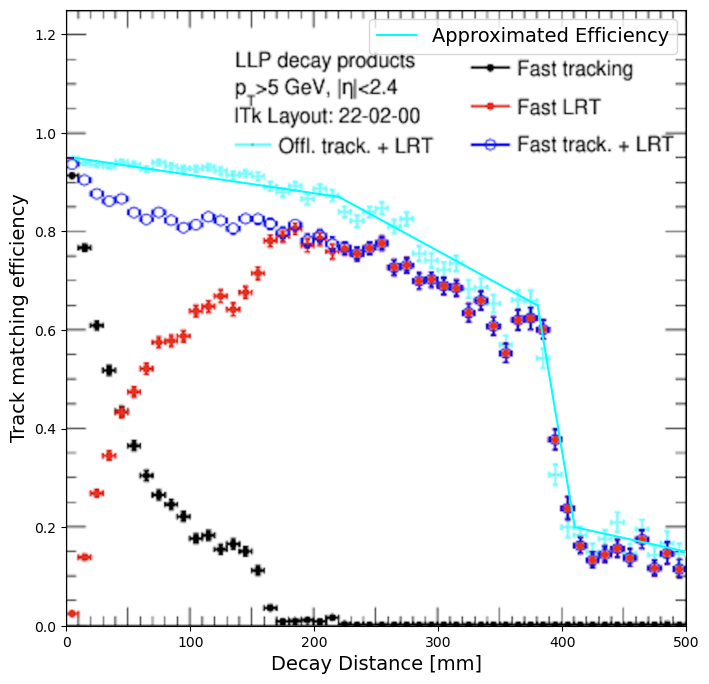

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load the uploaded figure as a background image
image_path = 'Figure_2'
img = mpimg.imread(image_path)

# Define the equations of the lines for the approximated efficiency curve
def Equation_of_a_Straight_Line(y_1, y_2, x_1, x_2):
    a = (y_2 - y_1) / (x_2 - x_1)
    b = y_1 - a * x_1
    x = np.linspace(x_1, x_2, 1000)
    y = a * x + b
    return y, x

# Define the points for the piecewise linear approximation
# y_10, x_10 = Equation_of_a_Straight_Line(0.95, 0.95, 0, 5)
y_1, x_1 = Equation_of_a_Straight_Line(0.95, 0.87, 5, 220)
y_2, x_2 = Equation_of_a_Straight_Line(0.87, 0.65, 220, 380)
y_3, x_3 = Equation_of_a_Straight_Line(0.65, 0.2, 380, 410)
y_4, x_4 = Equation_of_a_Straight_Line(0.2, 0.15, 410, 500)


# Plotting the figure and the approximated curve on top of it
fig, ax = plt.subplots(figsize=(8, 8))
# Display the image
ax.imshow(img, aspect='auto', extent=[0, 500, 0, 1.246])

# Plot the approximated efficiency curve on top
ax.plot(x_1, y_1, color='cyan', label='Approximated Efficiency')
ax.plot(x_2, y_2, color='cyan')
ax.plot(x_3, y_3, color='cyan')
ax.plot(x_4, y_4, color='cyan')
# ax.plot(x_10, y_10, color='purple')


# Set labels (assuming the original graph has the same labels and units)
ax.set_xlabel('Decay Distance [mm]', fontsize = 14)
ax.set_ylabel('Track matching efficiency', fontsize = 14)
ax.set_xlim(0,500)
ax.set_ylim(0,1.25)
ax.legend(fontsize = 14)

file_name = f'Approximated efficiency for track reconstruction'
save_figure(plt, file_name)

# Display the combined plot
plt.show()


In [ ]:
import numpy as np

# Translating the C++ function to Python
def Equation_of_a_Straight_Line(decay_distance):
    if 5 < decay_distance <= 220:
        y_1, y_2, x_1, x_2 = 0.95, 0.87, 0, 220
    elif 220 < decay_distance <= 380:
        y_1, y_2, x_1, x_2 = 0.87, 0.65, 220, 380
    elif 380 < decay_distance <= 410:
        y_1, y_2, x_1, x_2 = 0.65, 0.2, 380, 410
    elif 410 < decay_distance <= 500:
        y_1, y_2, x_1, x_2 = 0.2, 0.15, 410, 500
    else:
        return 0  # Return 0 efficiency if decay_distance doesn't fall into the defined ranges

    a = (y_2 - y_1) / (x_2 - x_1)
    b = y_1 - a * x_1
    efficiency = (a * decay_distance + b) ** 2
    
    return efficiency

# Example usage:
decay_distance = 275 # replace this with the actual decay distance to get the efficiency
efficiency = Equation_of_a_Straight_Line(decay_distance)
print(efficiency)


## 